# SAM workflow

### Generate binary masks of cones in microCT stack

This notebook performs the following tasks:

- Get means of YOLO Detections
- Use SAM to segment only the Bounding Boxes near the clusters

In [ ]:
# --- Core Libraries ---
import os                       # For interacting with the operating system (file paths, directories)
from pathlib import Path         # Object-oriented file system paths
import glob                      # File pattern matching for retrieving file lists
import math                      # Mathematical functions

# --- Image Processing Libraries ---
import cv2                       # OpenCV for advanced image/video processing
import numpy as np               # For numerical operations, arrays, and linear algebra
import pandas as pd              # For data manipulation and analysis
from skimage.io import imread    # To read images into arrays
from skimage import transform    # For image transformations (resize, rotate, etc.)
from skimage.filters import threshold_otsu  # For Otsu thresholding
from skimage.measure import regionprops     # For measuring properties of labeled regions
from PIL import Image            # Pillow library for image manipulation
from tifffile import imwrite     # To write TIFF images

# --- Plotting ---
import matplotlib.pyplot as plt  # For plotting images and graphs

# --- File Management ---
import shutil                    # For high-level file operations (copy, move, delete)

# --- Scientific Computation ---
from scipy.spatial import distance  # Compute distances between points
from scipy.stats import zscore       # Standardize data (z-score normalization)

# --- Machine Learning / Deep Learning ---
import torch                        # PyTorch for deep learning
from ultralytics import YOLO         # YOLO model for object detection
from sklearn.cluster import KMeans   # K-means clustering

# --- Utilities ---
from tqdm import tqdm               # Progress bars for loops
from tqdm.notebook import tqdm      # Progress bars specifically for Jupyter notebooks
import ast                           # For safely evaluating Python expressions from strings

# --- Pandas display options ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


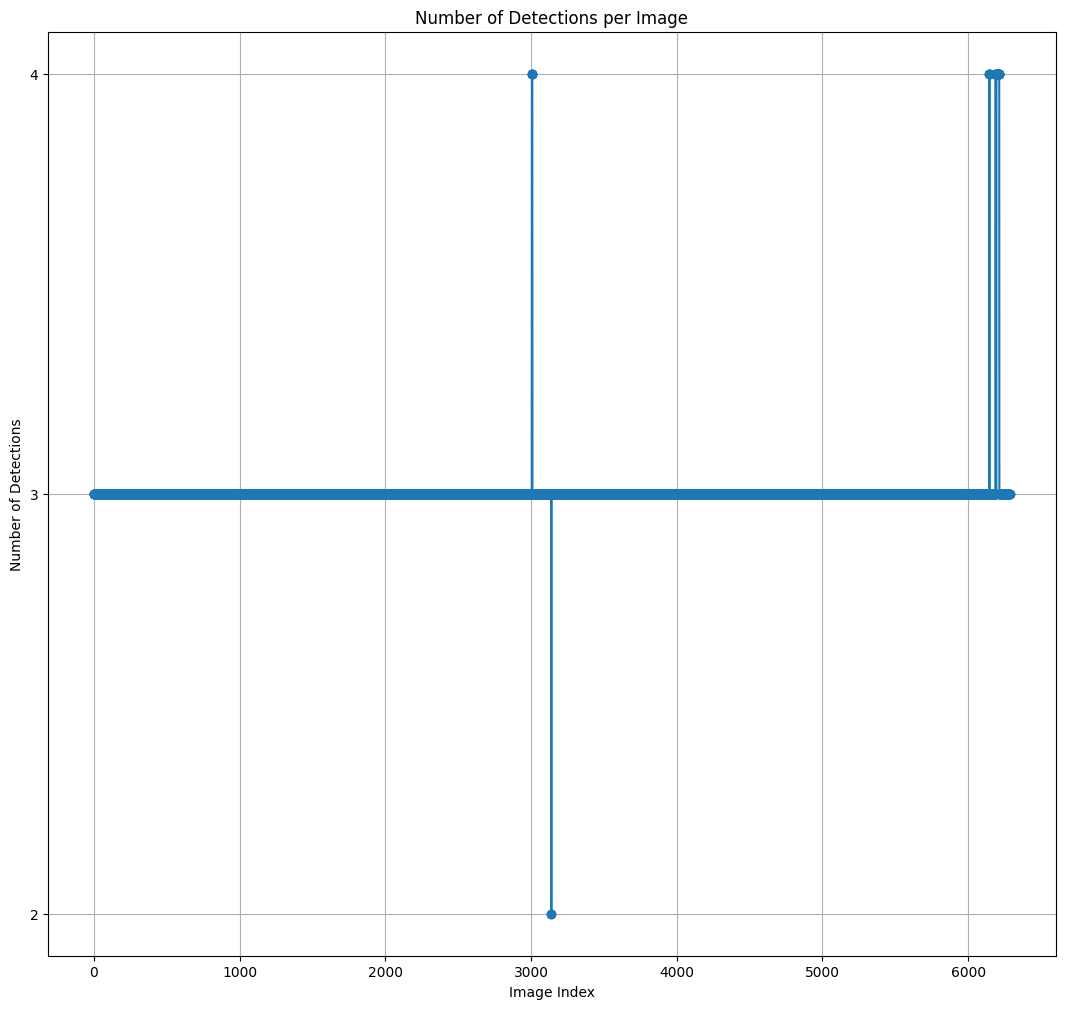

In [ ]:

# Read CSV
df_detect = pd.read_csv('df_detect.csv')

# Extract last column and filtered indices
num_cones = df_detect.iloc[:, 1]


# Create Plot
plt.figure(figsize=(13, 12))
plt.plot(num_cones, marker='o', linestyle='-')
plt.title('Number of Detections per Image')
plt.xlabel('Image Index')
plt.ylabel('Number of Detections')
plt.yticks([2, 3, 4])

# Ensure xticks are only multiples of 100 that exist in the index range

plt.grid(True)
plt.show()


In [5]:
im_list = np.load('im_list_full.npy')


Lower Bound: 0.5972668766975403, Upper Bound: 0.7972668766975403
Lower Bound: -0.03982988968491555, Upper Bound: 0.16017011031508446
Lower Bound: 0.26546292901039126, Upper Bound: 0.4654629290103912


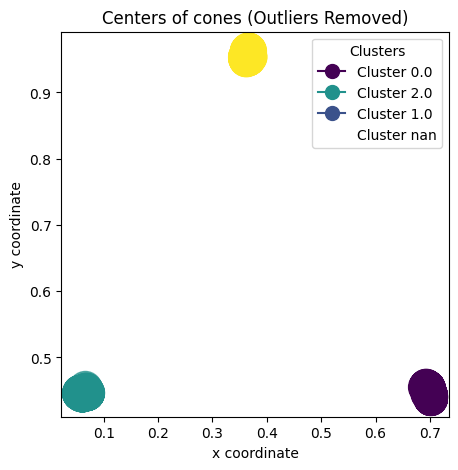

In [ ]:


def remove_outliers(df, threshold=20):
    # Calculate the median for the column
    median = df["x_center"].median()
    
    # Calculate the lower and upper bounds
    lower_bound = median - threshold
    upper_bound = median + threshold
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

    # Drop rows where the 'x_center' value is outside the bounds
    df_cleaned = df[(df["x_center"] >= lower_bound) & (df["x_center"] <= upper_bound)]
    
    return df_cleaned

# Assuming df_detect is your original dataframe

df = df_detect.copy()
df["Bbox"] = df["Bbox"].apply(ast.literal_eval)

# Extract X-center and Y-center from Bbox
df[["x_center", "y_center", "width", "height"]] = df["Bbox"].apply(lambda b: pd.Series([b[0], b[1], b[2], b[3]]))

# Set a threshold for removing outliers, e.g., 3 standard deviations

df_no_outliers = df.copy()



# Now apply K-Means clustering on the cleaned data (without outliers)
kmeans = KMeans(n_clusters=3, random_state=42)
df_no_outliers["cluster_label"] = kmeans.fit_predict(df_no_outliers[["x_center", "y_center"]])

for i in range(3):
    df_cluster= df_no_outliers[df_no_outliers["cluster_label"] == i]
    df_cluster_cleaned = remove_outliers(df_cluster, threshold=0.1)
    df_no_outliers[df_no_outliers["cluster_label"] == i] = df_cluster_cleaned



# Plotting the centers with clusters (after removing outliers)
plt.figure(figsize=(5, 5))
scatter = plt.scatter(df_no_outliers["x_center"], df_no_outliers["y_center"], s=550, c=df_no_outliers["cluster_label"], cmap='viridis', marker="o", alpha=0.7)

# Adding labels and title
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Centers of cones (Outliers Removed)")

# Dynamically create legend labels from unique cluster labels
import matplotlib.lines as mlines

legend_labels = []
for cluster in df_no_outliers["cluster_label"].unique():  # Loop through unique cluster labels
    cluster_color = plt.cm.viridis(cluster / len(df_no_outliers["cluster_label"].unique()))
    cluster_patch = mlines.Line2D([], [], color=cluster_color, marker='o', markersize=10, label=f'Cluster {cluster}')
    legend_labels.append(cluster_patch)

# Add custom legend
plt.legend(handles=legend_labels, title="Clusters")

# Show plot
plt.show()


In [7]:
h, w = im_list[0].shape 
cluster_means = df_no_outliers.groupby("cluster_label")[["x_center", "y_center"]].mean()
cluster_means["absolute_x_center"] = cluster_means["x_center"] * w
cluster_means["absolute_y_center"] = cluster_means["y_center"] * h
# Print the means of x_center and y_center for each cluster
print("Mean x_center and y_center for each cluster:")
print(cluster_means)

Mean x_center and y_center for each cluster:
               x_center  y_center  absolute_x_center  absolute_y_center
cluster_label                                                          
0.0            0.697590  0.448945        3344.245762        2318.353334
1.0            0.061907  0.445628         296.782723        2301.223410
2.0            0.365369  0.956379        1751.578490        4938.740483


In [ ]:
# Code used from the SAM2 repo https://github.com/facebookresearch/segment-anything

# If using Apple MPS (Metal Performance Shaders), allow PyTorch to fall back to CPU
# for operations not supported on the GPU. This avoids runtime errors on MPS devices.
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Set the device to CUDA (NVIDIA GPU). 
# If you are on Apple MPS or CPU-only machine, this should be adjusted accordingly.
device = torch.device("cuda")

# Seed the NumPy random number generator for reproducibility of random values.
np.random.seed(3)

def show_anns(anns, borders=True):
    """
    Display instance segmentation masks as an overlay on a blank image.
    """

    # If there are no annotations, do nothing
    if len(anns) == 0:
        return

    # Sort annotations by area (largest first)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    # Get current matplotlib axis for plotting
    ax = plt.gca()
    ax.set_autoscale_on(False)  # Prevent automatic rescaling of the axis

    # Create a blank RGBA image the same size as the first annotation's mask
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], 
                   sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0  # Set alpha channel to 0 (fully transparent)

    # Loop over each annotation
    for ann in sorted_anns:
        m = ann['segmentation']  # The binary mask for this annotation
        
        # Generate a random RGB color with fixed alpha (transparency)
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        
        # Apply the color to the mask pixels
        img[m] = color_mask 

        if borders:

            # Find contours in the mask
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            # Optional: smooth contours using polygon approximation
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            
            # Draw the contours on the RGBA image
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)  # Blue borders with some transparency

    # Display the final image with masks overlaid
    ax.imshow(img)


In [ ]:
# Import functions/classes for building the SAM2 model and generating masks
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Path to the SAM2 checkpoint file.
# This contains the pre-trained weights for the model.
sam2_checkpoint = "2_1/sam2/checkpoints/sam2.1_hiera_large.pt"

# Path to the model configuration YAML file.
# This defines the architecture and hyperparameters of SAM2.
model_cfg = "configs/sam2.1/sam2.1.hiera_l.yaml"

# Build the SAM2 model using the configuration and checkpoint.
# - device=device: sets the model to run on the chosen device (GPU/CPU/MPS)
# - apply_postprocessing=False: disables any postprocessing that might change the raw output masks
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# Initialize the automatic mask generator for SAM2
# This object can generate segmentation masks automatically from images
mask_generator = SAM2AutomaticMaskGenerator(sam2)




In [ ]:
# Get image height and width from the first image in the list
h, w = im_list[0].shape 

# Compute mean x and y centers for each cluster
cluster_means = df_no_outliers.groupby("cluster_label")[["x_center", "y_center"]].mean()

# Convert normalized centers to absolute pixel coordinates
cluster_means["absolute_x_center"] = cluster_means["x_center"] * w
cluster_means["absolute_y_center"] = cluster_means["y_center"] * h

# Display mean centers per cluster
print("Mean x_center and y_center for each cluster:")
print(cluster_means)




Mean x_center and y_center for each cluster:
               x_center  y_center  absolute_x_center  absolute_y_center
cluster_label                                                          
0.0            0.697590  0.448945        3344.245762        2318.353334
1.0            0.061907  0.445628         296.782723        2301.223410
2.0            0.365369  0.956379        1751.578490        4938.740483


1 590.0
0 705.0
2 736.0


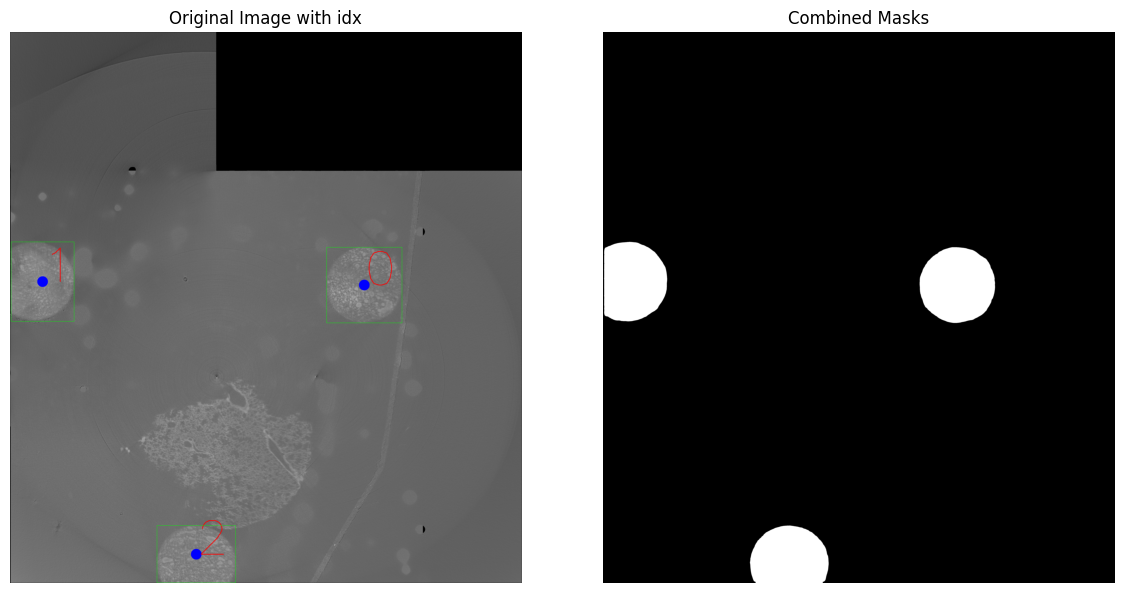

In [ ]:

# Load image and convert to RGB
im = imread("2_1/final/full_stack/final_full_stack0001.tif")
imrgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

# Generate masks (assumed you have mask_generator and cluster_means defined)
masks = mask_generator.generate(imrgb)


# Create a temporary image to store combined masks
im_temp = np.zeros_like(im)
aspect_ratio_threshold = 0.7

# Loop through masks and check conditions
for idx, mask in enumerate(masks):
    x, y, w, h = mask["bbox"]
    area = w * h
    min_area = 7506
    max_area = 910405

    # Check area and aspect ratio conditions
    
    if min_area <= area <= max_area:
        aspect_ratio = abs(w - h) / float(max(w, h))
      
        if aspect_ratio <= aspect_ratio_threshold:
            center_x = x + w / 2
            center_y = y + h / 2
        
            # Check distance to cluster centers
            for idx, (px, py) in enumerate(zip(cluster_means["absolute_x_center"], cluster_means["absolute_y_center"])):
                
                if abs(px - center_x) < 250 and abs(py - center_y) < 250:
                    # Print idx and width for debugging
                    print(idx, w)
                    cv2.circle(imrgb, (int(center_x), int(center_y)), 50, (0, 0, 255), -1)  # Red circle
                    # Draw the cluster index on the image
                    cv2.putText(imrgb, str(idx), 
                                (int(center_x), int(center_y)),  # Position of text (center of the bounding box)
                                cv2.FONT_HERSHEY_SIMPLEX, 15,  # Font type and size
                                (255, 0, 0), 5,  # Color (Blue), thickness
                                lineType=cv2.LINE_AA)
                    cv2.rectangle(imrgb, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)  # Green rectangle
                    
                    # Combine segmentation mask to temp image
                    segmentation = mask['segmentation']
                    im_temp = im_temp + segmentation

# Plot the images
plt.figure(figsize=(12, 6))

# Show the original image with idx annotations
plt.subplot(1, 2, 1)
plt.imshow(imrgb)  # Show original RGB image with idx drawn
plt.title("Original Image with idx")
plt.axis("off")

# Show the image with combined masks
plt.subplot(1, 2, 2)
plt.imshow(im_temp, cmap='gray')  # Show segmented image with a colormap
plt.title("Combined Masks")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
"""
This code iterates through all .tif images in a folder, generates segmentation masks using a SAM2 mask generator, and selects masks based
on area and aspect ratio criteria. It then checks if each mask is near predefined cluster centers, combines the valid masks into a single image,
and records metadata (image name, cluster label, width, height, center) in a list. Finally, it saves the combined mask images as PNGs and exports the metadata to a CSV file.
"""


# # Function to calculate the 2D distance between points
# def distance_2d(x1, y1, x2, y2):
#     return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# # Initialize variables
# aspect_ratio_threshold = 0.5
# min_area = 17506
# max_area = 910405
# output_data = []  # List to store image name, cluster label, and width

# # Folder path with images (adjust the path to your folder)
# image_folder = '/pn_local/2_1/final/MM_full_stack/'

# # Iterate through all .tif images in the folder
# image_files = sorted(glob.glob(os.path.join(image_folder, "*.tif")))
# #image_files = image_files[:250]
# # Iterate over each image
# for image_file in tqdm(image_files):
#     print(image_file)
#     im = imread(image_file)  # Read the image
#     imrgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
#     masks = mask_generator.generate(imrgb)  # Assuming mask_generator is defined earlier

#     im_temp = np.zeros_like(im)
    
#     # Iterate over each mask
#     for idx, mask in enumerate(masks):
#         x, y, w, h = mask["bbox"]
#         area = w * h
        
#         # Check if the area is within the desired range
#         if min_area <= area <= max_area:
#             aspect_ratio = abs(w - h) / float(max(w, h))
            
#             # Check if aspect ratio is below the threshold
#             if aspect_ratio <= aspect_ratio_threshold:
#                 center_x = x + w / 2
#                 center_y = y + h / 2
                
#                 # Iterate through the cluster centers
#                 for idx,(px, py) in enumerate(zip(cluster_means["absolute_x_center"], cluster_means["absolute_y_center"])):
#                     #distance = distance_2d(px, py, center_x, center_y)
#                     #print(idx)
#                     # If the distance is within threshold, add the segmentation
#                     if abs(px - center_x) < 50 and abs(py - center_y)<80 :
#                         segmentation = mask['segmentation']
#                         im_temp += segmentation

#                         # Store the information (image name, cluster label, and width)
#                         output_data.append({
#                             "image_name": os.path.basename(image_file),  # Save only the filename
#                             "cluster_label": idx,  # Assuming 'label' exists in cluster_means
#                             "width": w,
#                             "height": h,
#                             "center": [center_x,center_y],
#                         })
    
#     # Save the processed image as a PNG file
#     output_image_path = os.path.join("SAM_Output/MM_SAM_Output", f"combined_mask_{os.path.basename(image_file)}")
#     if not os.path.exists(output_image_path):
#         cv2.imwrite(output_image_path, im_temp * 255)  # Save the combined mask image
#         #print(f"Saved: {output_image_path}")
#     else:
#         print(f"Skipped (already exists): {output_image_path}")

# # Convert the output data to a DataFrame for better visualization
# df_output = pd.DataFrame(output_data)

# # Save the output data to a CSV file
# df_output.to_csv("MM_image_cluster_labels_widths_heights_centers.csv", index=False)

# # # Optionally display the image results
# # plt.figure(figsize=(12, 6))

# # # Show the original image (first one in the list as an example)
# # plt.subplot(1, 2, 1)
# # plt.imshow(im)  # Show original RGB image
# # plt.title("Original Image")
# # plt.axis("off")

# # # Show the image with combined circular masks
# # plt.subplot(1, 2, 2)
# # plt.imshow(im_temp, cmap='grey')  # Show segmented image with a colormap
# # plt.title("Combined Circular Masks")
# # plt.axis("off")

# # plt.tight_layout()
# # plt.show()


  0%|          | 0/1983 [00:00<?, ?it/s]

/pn_local/2_1/final/MM_full_stack/MM_final_0000.tif


  0%|          | 1/1983 [00:03<2:00:21,  3.64s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0000.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0001.tif


  0%|          | 2/1983 [00:07<2:06:00,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0001.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0002.tif


  0%|          | 3/1983 [00:11<2:05:58,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0002.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0003.tif


  0%|          | 4/1983 [00:15<2:08:04,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0003.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0004.tif


  0%|          | 5/1983 [00:19<2:08:01,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0004.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0005.tif


  0%|          | 6/1983 [00:23<2:08:19,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0005.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0006.tif


  0%|          | 7/1983 [00:27<2:07:44,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0006.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0007.tif


  0%|          | 8/1983 [00:30<2:07:43,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0007.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0008.tif


  0%|          | 9/1983 [00:34<2:07:12,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0008.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0009.tif


  1%|          | 10/1983 [00:38<2:05:37,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0009.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0010.tif


  1%|          | 11/1983 [00:41<2:02:08,  3.72s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0010.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0011.tif


  1%|          | 12/1983 [00:45<2:00:49,  3.68s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0011.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0012.tif


  1%|          | 13/1983 [00:48<1:58:07,  3.60s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0012.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0013.tif


  1%|          | 14/1983 [00:52<1:56:08,  3.54s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0013.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0014.tif


  1%|          | 15/1983 [00:55<1:56:27,  3.55s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0014.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0015.tif


  1%|          | 16/1983 [00:59<1:58:14,  3.61s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0015.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0016.tif


  1%|          | 17/1983 [01:03<1:59:06,  3.64s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0016.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0017.tif


  1%|          | 18/1983 [01:07<2:00:13,  3.67s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0017.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0018.tif


  1%|          | 19/1983 [01:10<1:59:44,  3.66s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0018.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0019.tif


  1%|          | 20/1983 [01:14<2:00:22,  3.68s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0019.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0020.tif


  1%|          | 21/1983 [01:18<2:00:03,  3.67s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0020.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0021.tif


  1%|          | 22/1983 [01:21<1:59:53,  3.67s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0021.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0022.tif


  1%|          | 23/1983 [01:25<2:00:33,  3.69s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0022.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0023.tif


  1%|          | 24/1983 [01:29<2:03:41,  3.79s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0023.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0024.tif


  1%|▏         | 25/1983 [01:33<2:08:40,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0024.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0025.tif


  1%|▏         | 26/1983 [01:37<2:09:33,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0025.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0026.tif


  1%|▏         | 27/1983 [01:41<2:09:04,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0026.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0027.tif


  1%|▏         | 28/1983 [01:45<2:06:31,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0027.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0028.tif


  1%|▏         | 29/1983 [01:49<2:07:41,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0028.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0029.tif


  2%|▏         | 30/1983 [01:53<2:06:50,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0029.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0030.tif


  2%|▏         | 31/1983 [01:57<2:07:42,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0030.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0031.tif


  2%|▏         | 32/1983 [02:01<2:06:30,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0031.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0032.tif


  2%|▏         | 33/1983 [02:05<2:06:55,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0032.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0033.tif


  2%|▏         | 34/1983 [02:08<2:06:01,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0033.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0034.tif


  2%|▏         | 35/1983 [02:12<2:06:22,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0034.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0035.tif


  2%|▏         | 36/1983 [02:16<2:04:55,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0035.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0036.tif


  2%|▏         | 37/1983 [02:20<2:03:34,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0036.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0037.tif


  2%|▏         | 38/1983 [02:24<2:02:37,  3.78s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0037.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0038.tif


  2%|▏         | 39/1983 [02:28<2:04:20,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0038.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0039.tif


  2%|▏         | 40/1983 [02:31<2:03:19,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0039.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0040.tif


  2%|▏         | 41/1983 [02:35<2:04:27,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0040.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0041.tif


  2%|▏         | 42/1983 [02:39<2:03:48,  3.83s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0041.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0042.tif


  2%|▏         | 43/1983 [02:43<2:04:50,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0042.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0043.tif


  2%|▏         | 44/1983 [02:47<2:06:51,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0043.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0044.tif


  2%|▏         | 45/1983 [02:51<2:08:49,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0044.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0045.tif


  2%|▏         | 46/1983 [02:55<2:08:02,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0045.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0046.tif


  2%|▏         | 47/1983 [02:59<2:09:20,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0046.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0047.tif


  2%|▏         | 48/1983 [03:03<2:08:01,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0047.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0048.tif


  2%|▏         | 49/1983 [03:07<2:08:05,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0048.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0049.tif


  3%|▎         | 50/1983 [03:11<2:07:31,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0049.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0050.tif


  3%|▎         | 51/1983 [03:15<2:06:28,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0050.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0051.tif


  3%|▎         | 52/1983 [03:19<2:06:55,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0051.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0052.tif


  3%|▎         | 53/1983 [03:23<2:09:20,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0052.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0053.tif


  3%|▎         | 54/1983 [03:27<2:09:53,  4.04s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0053.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0054.tif


  3%|▎         | 55/1983 [03:31<2:12:58,  4.14s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0054.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0055.tif


  3%|▎         | 56/1983 [03:36<2:12:40,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0055.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0056.tif


  3%|▎         | 57/1983 [03:40<2:12:25,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0056.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0057.tif


  3%|▎         | 58/1983 [03:44<2:09:57,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0057.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0058.tif


  3%|▎         | 59/1983 [03:48<2:10:42,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0058.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0059.tif


  3%|▎         | 60/1983 [03:52<2:08:59,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0059.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0060.tif


  3%|▎         | 61/1983 [03:56<2:10:13,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0060.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0061.tif


  3%|▎         | 62/1983 [04:00<2:09:22,  4.04s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0061.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0062.tif


  3%|▎         | 63/1983 [04:04<2:09:42,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0062.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0063.tif


  3%|▎         | 64/1983 [04:08<2:08:03,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0063.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0064.tif


  3%|▎         | 65/1983 [04:12<2:08:15,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0064.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0065.tif


  3%|▎         | 66/1983 [04:16<2:08:06,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0065.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0066.tif


  3%|▎         | 67/1983 [04:20<2:09:59,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0066.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0067.tif


  3%|▎         | 68/1983 [04:24<2:10:44,  4.10s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0067.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0068.tif


  3%|▎         | 69/1983 [04:28<2:09:35,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0068.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0069.tif


  4%|▎         | 70/1983 [04:32<2:06:49,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0069.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0070.tif


  4%|▎         | 71/1983 [04:36<2:06:31,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0070.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0071.tif


  4%|▎         | 72/1983 [04:39<2:03:33,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0071.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0072.tif


  4%|▎         | 73/1983 [04:44<2:05:41,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0072.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0073.tif


  4%|▎         | 74/1983 [04:48<2:06:51,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0073.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0074.tif


  4%|▍         | 75/1983 [04:52<2:08:16,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0074.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0075.tif


  4%|▍         | 76/1983 [04:56<2:06:29,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0075.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0076.tif


  4%|▍         | 77/1983 [05:00<2:06:46,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0076.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0077.tif


  4%|▍         | 78/1983 [05:03<2:04:30,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0077.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0078.tif


  4%|▍         | 79/1983 [05:07<2:04:16,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0078.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0079.tif


  4%|▍         | 80/1983 [05:11<2:01:58,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0079.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0080.tif


  4%|▍         | 81/1983 [05:15<1:59:17,  3.76s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0080.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0081.tif


  4%|▍         | 82/1983 [05:18<1:57:37,  3.71s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0081.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0082.tif


  4%|▍         | 83/1983 [05:22<1:57:49,  3.72s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0082.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0083.tif


  4%|▍         | 84/1983 [05:26<1:59:02,  3.76s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0083.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0084.tif


  4%|▍         | 85/1983 [05:30<1:59:03,  3.76s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0084.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0085.tif


  4%|▍         | 86/1983 [05:33<1:58:23,  3.74s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0085.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0086.tif


  4%|▍         | 87/1983 [05:37<2:00:34,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0086.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0087.tif


  4%|▍         | 88/1983 [05:41<2:01:16,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0087.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0088.tif


  4%|▍         | 89/1983 [05:45<2:02:15,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0088.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0089.tif


  5%|▍         | 90/1983 [05:49<2:03:36,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0089.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0090.tif


  5%|▍         | 91/1983 [05:53<2:05:17,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0090.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0091.tif


  5%|▍         | 92/1983 [05:57<2:05:58,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0091.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0092.tif


  5%|▍         | 93/1983 [06:01<2:06:02,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0092.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0093.tif


  5%|▍         | 94/1983 [06:05<2:05:29,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0093.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0094.tif


  5%|▍         | 95/1983 [06:09<2:05:55,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0094.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0095.tif


  5%|▍         | 96/1983 [06:13<2:04:30,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0095.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0096.tif


  5%|▍         | 97/1983 [06:17<2:01:22,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0096.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0097.tif


  5%|▍         | 98/1983 [06:20<1:58:32,  3.77s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0097.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0098.tif


  5%|▍         | 99/1983 [06:24<1:56:52,  3.72s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0098.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0099.tif


  5%|▌         | 100/1983 [06:28<1:57:11,  3.73s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0099.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0100.tif


  5%|▌         | 101/1983 [06:32<1:58:08,  3.77s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0100.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0101.tif


  5%|▌         | 102/1983 [06:35<1:59:36,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0101.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0102.tif


  5%|▌         | 103/1983 [06:39<2:01:16,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0102.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0103.tif


  5%|▌         | 104/1983 [06:44<2:03:53,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0103.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0104.tif


  5%|▌         | 105/1983 [06:48<2:05:18,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0104.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0105.tif


  5%|▌         | 106/1983 [06:52<2:04:09,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0105.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0106.tif


  5%|▌         | 107/1983 [06:56<2:05:53,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0106.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0107.tif


  5%|▌         | 108/1983 [07:00<2:05:12,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0107.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0108.tif


  5%|▌         | 109/1983 [07:04<2:04:31,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0108.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0109.tif


  6%|▌         | 110/1983 [07:07<2:02:49,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0109.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0110.tif


  6%|▌         | 111/1983 [07:11<2:03:25,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0110.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0111.tif


  6%|▌         | 112/1983 [07:15<2:02:36,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0111.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0112.tif


  6%|▌         | 113/1983 [07:19<2:03:03,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0112.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0113.tif


  6%|▌         | 114/1983 [07:23<2:02:56,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0113.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0114.tif


  6%|▌         | 115/1983 [07:27<2:02:34,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0114.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0115.tif


  6%|▌         | 116/1983 [07:31<2:01:55,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0115.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0116.tif


  6%|▌         | 117/1983 [07:35<2:00:15,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0116.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0117.tif


  6%|▌         | 118/1983 [07:38<1:56:41,  3.75s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0117.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0118.tif


  6%|▌         | 119/1983 [07:42<1:55:34,  3.72s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0118.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0119.tif


  6%|▌         | 120/1983 [07:46<1:55:35,  3.72s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0119.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0120.tif


  6%|▌         | 121/1983 [07:50<1:57:26,  3.78s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0120.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0121.tif


  6%|▌         | 122/1983 [07:53<1:57:09,  3.78s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0121.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0122.tif


  6%|▌         | 123/1983 [07:57<1:58:34,  3.83s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0122.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0123.tif


  6%|▋         | 124/1983 [08:01<1:58:32,  3.83s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0123.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0124.tif


  6%|▋         | 125/1983 [08:05<1:59:28,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0124.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0125.tif


  6%|▋         | 126/1983 [08:09<1:58:39,  3.83s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0125.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0126.tif


  6%|▋         | 127/1983 [08:13<2:00:18,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0126.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0127.tif


  6%|▋         | 128/1983 [08:17<2:01:51,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0127.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0128.tif


  7%|▋         | 129/1983 [08:21<2:05:09,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0128.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0129.tif


  7%|▋         | 130/1983 [08:25<2:06:28,  4.10s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0129.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0130.tif


  7%|▋         | 131/1983 [08:29<2:05:53,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0130.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0131.tif


  7%|▋         | 132/1983 [08:34<2:05:50,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0131.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0132.tif


  7%|▋         | 133/1983 [08:38<2:05:19,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0132.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0133.tif


  7%|▋         | 134/1983 [08:41<2:03:14,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0133.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0134.tif


  7%|▋         | 135/1983 [08:46<2:04:04,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0134.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0135.tif


  7%|▋         | 136/1983 [08:50<2:03:27,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0135.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0136.tif


  7%|▋         | 137/1983 [08:54<2:04:45,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0136.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0137.tif


  7%|▋         | 138/1983 [08:58<2:05:02,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0137.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0138.tif


  7%|▋         | 139/1983 [09:02<2:07:51,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0138.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0139.tif


  7%|▋         | 140/1983 [09:06<2:07:54,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0139.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0140.tif


  7%|▋         | 141/1983 [09:10<2:07:43,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0140.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0141.tif


  7%|▋         | 142/1983 [09:15<2:06:37,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0141.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0142.tif


  7%|▋         | 143/1983 [09:19<2:08:02,  4.18s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0142.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0143.tif


  7%|▋         | 144/1983 [09:23<2:06:23,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0143.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0144.tif


  7%|▋         | 145/1983 [09:27<2:06:00,  4.11s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0144.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0145.tif


  7%|▋         | 146/1983 [09:31<2:03:59,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0145.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0146.tif


  7%|▋         | 147/1983 [09:35<2:02:54,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0146.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0147.tif


  7%|▋         | 148/1983 [09:39<2:02:14,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0147.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0148.tif


  8%|▊         | 149/1983 [09:43<2:03:06,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0148.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0149.tif


  8%|▊         | 150/1983 [09:47<2:01:40,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0149.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0150.tif


  8%|▊         | 151/1983 [09:51<2:01:22,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0150.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0151.tif


  8%|▊         | 152/1983 [09:54<2:00:06,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0151.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0152.tif


  8%|▊         | 153/1983 [09:58<2:01:00,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0152.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0153.tif


  8%|▊         | 154/1983 [10:02<2:00:23,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0153.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0154.tif


  8%|▊         | 155/1983 [10:07<2:02:07,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0154.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0155.tif


  8%|▊         | 156/1983 [10:11<2:03:34,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0155.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0156.tif


  8%|▊         | 157/1983 [10:15<2:04:04,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0156.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0157.tif


  8%|▊         | 158/1983 [10:19<2:04:20,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0157.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0158.tif


  8%|▊         | 159/1983 [10:23<2:05:32,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0158.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0159.tif


  8%|▊         | 160/1983 [10:27<2:04:08,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0159.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0160.tif


  8%|▊         | 161/1983 [10:31<2:05:41,  4.14s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0160.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0161.tif


  8%|▊         | 162/1983 [10:36<2:05:09,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0161.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0162.tif


  8%|▊         | 163/1983 [10:40<2:05:37,  4.14s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0162.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0163.tif


  8%|▊         | 164/1983 [10:44<2:06:17,  4.17s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0163.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0164.tif


  8%|▊         | 165/1983 [10:48<2:07:27,  4.21s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0164.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0165.tif


  8%|▊         | 166/1983 [10:52<2:05:45,  4.15s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0165.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0166.tif


  8%|▊         | 167/1983 [10:56<2:05:57,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0166.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0167.tif


  8%|▊         | 168/1983 [11:01<2:05:43,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0167.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0168.tif


  9%|▊         | 169/1983 [11:05<2:04:25,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0168.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0169.tif


  9%|▊         | 170/1983 [11:09<2:05:09,  4.14s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0169.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0170.tif


  9%|▊         | 171/1983 [11:13<2:06:04,  4.17s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0170.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0171.tif


  9%|▊         | 172/1983 [11:17<2:06:23,  4.19s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0171.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0172.tif


  9%|▊         | 173/1983 [11:22<2:06:47,  4.20s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0172.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0173.tif


  9%|▉         | 174/1983 [11:26<2:07:34,  4.23s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0173.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0174.tif


  9%|▉         | 175/1983 [11:30<2:08:12,  4.25s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0174.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0175.tif


  9%|▉         | 176/1983 [11:34<2:05:50,  4.18s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0175.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0176.tif


  9%|▉         | 177/1983 [11:38<2:05:09,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0176.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0177.tif


  9%|▉         | 178/1983 [11:42<2:02:50,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0177.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0178.tif


  9%|▉         | 179/1983 [11:46<2:03:09,  4.10s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0178.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0179.tif


  9%|▉         | 180/1983 [11:50<2:01:41,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0179.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0180.tif


  9%|▉         | 181/1983 [11:54<2:01:08,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0180.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0181.tif


  9%|▉         | 182/1983 [11:58<2:00:40,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0181.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0182.tif


  9%|▉         | 183/1983 [12:02<2:00:43,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0182.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0183.tif


  9%|▉         | 184/1983 [12:06<2:00:19,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0183.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0184.tif


  9%|▉         | 185/1983 [12:10<2:00:12,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0184.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0185.tif


  9%|▉         | 186/1983 [12:14<2:01:20,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0185.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0186.tif


  9%|▉         | 187/1983 [12:19<2:02:57,  4.11s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0186.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0187.tif


  9%|▉         | 188/1983 [12:23<2:02:32,  4.10s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0187.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0188.tif


 10%|▉         | 189/1983 [12:27<2:02:22,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0188.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0189.tif


 10%|▉         | 190/1983 [12:31<2:01:57,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0189.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0190.tif


 10%|▉         | 191/1983 [12:35<2:03:12,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0190.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0191.tif


 10%|▉         | 192/1983 [12:39<2:03:00,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0191.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0192.tif


 10%|▉         | 193/1983 [12:43<2:03:42,  4.15s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0192.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0193.tif


 10%|▉         | 194/1983 [12:47<2:02:04,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0193.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0194.tif


 10%|▉         | 195/1983 [12:51<2:01:21,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0194.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0195.tif


 10%|▉         | 196/1983 [12:55<1:59:45,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0195.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0196.tif


 10%|▉         | 197/1983 [12:59<2:00:34,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0196.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0197.tif


 10%|▉         | 198/1983 [13:03<1:58:42,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0197.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0198.tif


 10%|█         | 199/1983 [13:07<1:59:01,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0198.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0199.tif


 10%|█         | 200/1983 [13:11<2:00:34,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0199.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0200.tif


 10%|█         | 201/1983 [13:16<2:02:08,  4.11s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0200.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0201.tif


 10%|█         | 202/1983 [13:20<2:02:19,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0201.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0202.tif


 10%|█         | 203/1983 [13:24<2:03:57,  4.18s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0202.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0203.tif


 10%|█         | 204/1983 [13:28<2:04:35,  4.20s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0203.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0204.tif


 10%|█         | 205/1983 [13:33<2:04:06,  4.19s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0204.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0205.tif


 10%|█         | 206/1983 [13:37<2:02:30,  4.14s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0205.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0206.tif


 10%|█         | 207/1983 [13:41<2:02:00,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0206.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0207.tif


 10%|█         | 208/1983 [13:45<2:02:39,  4.15s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0207.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0208.tif


 11%|█         | 209/1983 [13:49<2:03:19,  4.17s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0208.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0209.tif


 11%|█         | 210/1983 [13:53<2:04:41,  4.22s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0209.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0210.tif


 11%|█         | 211/1983 [13:58<2:04:39,  4.22s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0210.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0211.tif


 11%|█         | 212/1983 [14:02<2:03:37,  4.19s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0211.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0212.tif


 11%|█         | 213/1983 [14:06<2:03:03,  4.17s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0212.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0213.tif


 11%|█         | 214/1983 [14:10<2:03:02,  4.17s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0213.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0214.tif


 11%|█         | 215/1983 [14:14<2:01:23,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0214.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0215.tif


 11%|█         | 216/1983 [14:18<2:02:05,  4.15s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0215.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0216.tif


 11%|█         | 217/1983 [14:22<2:01:17,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0216.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0217.tif


 11%|█         | 218/1983 [14:26<2:00:58,  4.11s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0217.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0218.tif


 11%|█         | 219/1983 [14:30<2:00:02,  4.08s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0218.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0219.tif


 11%|█         | 220/1983 [14:35<2:00:05,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0219.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0220.tif


 11%|█         | 221/1983 [14:39<2:01:01,  4.12s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0220.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0221.tif


 11%|█         | 222/1983 [14:43<2:02:43,  4.18s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0221.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0222.tif


 11%|█         | 223/1983 [14:47<2:01:38,  4.15s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0222.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0223.tif


 11%|█▏        | 224/1983 [14:51<2:02:31,  4.18s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0223.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0224.tif


 11%|█▏        | 225/1983 [14:55<2:01:47,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0224.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0225.tif


 11%|█▏        | 226/1983 [14:59<2:00:28,  4.11s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0225.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0226.tif


 11%|█▏        | 227/1983 [15:04<2:01:30,  4.15s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0226.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0227.tif


 11%|█▏        | 228/1983 [15:08<2:02:48,  4.20s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0227.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0228.tif


 12%|█▏        | 229/1983 [15:12<2:02:41,  4.20s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0228.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0229.tif


 12%|█▏        | 230/1983 [15:16<2:00:41,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0229.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0230.tif


 12%|█▏        | 231/1983 [15:20<2:00:07,  4.11s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0230.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0231.tif


 12%|█▏        | 232/1983 [15:24<1:58:26,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0231.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0232.tif


 12%|█▏        | 233/1983 [15:28<1:59:21,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0232.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0233.tif


 12%|█▏        | 234/1983 [15:33<2:00:14,  4.13s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0233.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0234.tif


 12%|█▏        | 235/1983 [15:37<2:00:43,  4.14s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0234.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0235.tif


 12%|█▏        | 236/1983 [15:41<2:01:11,  4.16s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0235.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0236.tif


 12%|█▏        | 237/1983 [15:45<1:59:06,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0236.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0237.tif


 12%|█▏        | 238/1983 [15:49<1:59:19,  4.10s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0237.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0238.tif


 12%|█▏        | 239/1983 [15:53<1:57:58,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0238.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0239.tif


 12%|█▏        | 240/1983 [15:57<1:57:36,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0239.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0240.tif


 12%|█▏        | 241/1983 [16:01<1:57:15,  4.04s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0240.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0241.tif


 12%|█▏        | 242/1983 [16:05<1:55:22,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0241.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0242.tif


 12%|█▏        | 243/1983 [16:09<1:56:08,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0242.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0243.tif


 12%|█▏        | 244/1983 [16:13<1:56:56,  4.04s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0243.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0244.tif


 12%|█▏        | 245/1983 [16:17<1:57:58,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0244.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0245.tif


 12%|█▏        | 246/1983 [16:21<1:57:37,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0245.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0246.tif


 12%|█▏        | 247/1983 [16:25<1:55:55,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0246.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0247.tif


 13%|█▎        | 248/1983 [16:29<1:56:10,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0247.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0248.tif


 13%|█▎        | 249/1983 [16:33<1:55:44,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0248.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0249.tif


 13%|█▎        | 250/1983 [16:37<1:55:06,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0249.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0250.tif


 13%|█▎        | 251/1983 [16:41<1:55:39,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0250.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0251.tif


 13%|█▎        | 252/1983 [16:45<1:56:06,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0251.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0252.tif


 13%|█▎        | 253/1983 [16:49<1:55:00,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0252.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0253.tif


 13%|█▎        | 254/1983 [16:53<1:53:55,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0253.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0254.tif


 13%|█▎        | 255/1983 [16:57<1:52:07,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0254.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0255.tif


 13%|█▎        | 256/1983 [17:01<1:51:42,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0255.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0256.tif


 13%|█▎        | 257/1983 [17:04<1:50:42,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0256.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0257.tif


 13%|█▎        | 258/1983 [17:08<1:51:54,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0257.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0258.tif


 13%|█▎        | 259/1983 [17:12<1:51:30,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0258.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0259.tif


 13%|█▎        | 260/1983 [17:16<1:51:58,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0259.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0260.tif


 13%|█▎        | 261/1983 [17:20<1:51:18,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0260.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0261.tif


 13%|█▎        | 262/1983 [17:24<1:52:42,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0261.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0262.tif


 13%|█▎        | 263/1983 [17:28<1:52:48,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0262.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0263.tif


 13%|█▎        | 264/1983 [17:32<1:53:21,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0263.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0264.tif


 13%|█▎        | 265/1983 [17:36<1:51:26,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0264.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0265.tif


 13%|█▎        | 266/1983 [17:40<1:51:13,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0265.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0266.tif


 13%|█▎        | 267/1983 [17:43<1:50:19,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0266.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0267.tif


 14%|█▎        | 268/1983 [17:47<1:48:58,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0267.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0268.tif


 14%|█▎        | 269/1983 [17:51<1:48:39,  3.80s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0268.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0269.tif


 14%|█▎        | 270/1983 [17:55<1:49:32,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0269.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0270.tif


 14%|█▎        | 271/1983 [17:58<1:48:14,  3.79s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0270.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0271.tif


 14%|█▎        | 272/1983 [18:02<1:47:53,  3.78s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0271.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0272.tif


 14%|█▍        | 273/1983 [18:06<1:48:33,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0272.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0273.tif


 14%|█▍        | 274/1983 [18:10<1:52:02,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0273.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0274.tif


 14%|█▍        | 275/1983 [18:14<1:51:57,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0274.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0275.tif


 14%|█▍        | 276/1983 [18:18<1:53:28,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0275.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0276.tif


 14%|█▍        | 277/1983 [18:22<1:52:08,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0276.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0277.tif


 14%|█▍        | 278/1983 [18:26<1:52:41,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0277.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0278.tif


 14%|█▍        | 279/1983 [18:30<1:51:37,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0278.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0279.tif


 14%|█▍        | 280/1983 [18:34<1:51:30,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0279.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0280.tif


 14%|█▍        | 281/1983 [18:38<1:51:05,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0280.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0281.tif


 14%|█▍        | 282/1983 [18:42<1:50:04,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0281.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0282.tif


 14%|█▍        | 283/1983 [18:45<1:49:14,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0282.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0283.tif


 14%|█▍        | 284/1983 [18:49<1:49:03,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0283.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0284.tif


 14%|█▍        | 285/1983 [18:53<1:49:25,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0284.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0285.tif


 14%|█▍        | 286/1983 [18:57<1:48:08,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0285.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0286.tif


 14%|█▍        | 287/1983 [19:01<1:49:13,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0286.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0287.tif


 15%|█▍        | 288/1983 [19:05<1:48:04,  3.83s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0287.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0288.tif


 15%|█▍        | 289/1983 [19:09<1:48:53,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0288.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0289.tif


 15%|█▍        | 290/1983 [19:12<1:48:17,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0289.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0290.tif


 15%|█▍        | 291/1983 [19:16<1:48:32,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0290.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0291.tif


 15%|█▍        | 292/1983 [19:20<1:47:23,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0291.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0292.tif


 15%|█▍        | 293/1983 [19:24<1:45:39,  3.75s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0292.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0293.tif


 15%|█▍        | 294/1983 [19:27<1:43:43,  3.68s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0293.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0294.tif


 15%|█▍        | 295/1983 [19:31<1:43:14,  3.67s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0294.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0295.tif


 15%|█▍        | 296/1983 [19:34<1:42:59,  3.66s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0295.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0296.tif


 15%|█▍        | 297/1983 [19:38<1:43:14,  3.67s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0296.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0297.tif


 15%|█▌        | 298/1983 [19:42<1:42:15,  3.64s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0297.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0298.tif


 15%|█▌        | 299/1983 [19:45<1:41:44,  3.62s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0298.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0299.tif


 15%|█▌        | 300/1983 [19:49<1:42:27,  3.65s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0299.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0300.tif


 15%|█▌        | 301/1983 [19:53<1:43:56,  3.71s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0300.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0301.tif


 15%|█▌        | 302/1983 [19:57<1:44:03,  3.71s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0301.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0302.tif


 15%|█▌        | 303/1983 [20:00<1:45:14,  3.76s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0302.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0303.tif


 15%|█▌        | 304/1983 [20:04<1:43:31,  3.70s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0303.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0304.tif


 15%|█▌        | 305/1983 [20:08<1:44:08,  3.72s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0304.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0305.tif


 15%|█▌        | 306/1983 [20:11<1:44:19,  3.73s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0305.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0306.tif


 15%|█▌        | 307/1983 [20:15<1:43:42,  3.71s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0306.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0307.tif


 16%|█▌        | 308/1983 [20:19<1:43:08,  3.69s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0307.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0308.tif


 16%|█▌        | 309/1983 [20:23<1:44:07,  3.73s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0308.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0309.tif


 16%|█▌        | 310/1983 [20:27<1:46:20,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0309.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0310.tif


 16%|█▌        | 311/1983 [20:30<1:46:38,  3.83s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0310.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0311.tif


 16%|█▌        | 312/1983 [20:34<1:46:54,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0311.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0312.tif


 16%|█▌        | 313/1983 [20:38<1:47:17,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0312.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0313.tif


 16%|█▌        | 314/1983 [20:42<1:47:43,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0313.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0314.tif


 16%|█▌        | 315/1983 [20:46<1:48:22,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0314.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0315.tif


 16%|█▌        | 316/1983 [20:50<1:47:10,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0315.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0316.tif


 16%|█▌        | 317/1983 [20:54<1:46:44,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0316.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0317.tif


 16%|█▌        | 318/1983 [20:58<1:47:08,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0317.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0318.tif


 16%|█▌        | 319/1983 [21:01<1:45:30,  3.80s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0318.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0319.tif


 16%|█▌        | 320/1983 [21:05<1:46:26,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0319.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0320.tif


 16%|█▌        | 321/1983 [21:09<1:47:23,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0320.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0321.tif


 16%|█▌        | 322/1983 [21:13<1:49:04,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0321.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0322.tif


 16%|█▋        | 323/1983 [21:17<1:48:11,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0322.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0323.tif


 16%|█▋        | 324/1983 [21:21<1:48:17,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0323.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0324.tif


 16%|█▋        | 325/1983 [21:25<1:47:02,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0324.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0325.tif


 16%|█▋        | 326/1983 [21:29<1:46:10,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0325.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0326.tif


 16%|█▋        | 327/1983 [21:33<1:47:02,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0326.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0327.tif


 17%|█▋        | 328/1983 [21:36<1:47:23,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0327.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0328.tif


 17%|█▋        | 329/1983 [21:40<1:46:19,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0328.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0329.tif


 17%|█▋        | 330/1983 [21:44<1:46:44,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0329.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0330.tif


 17%|█▋        | 331/1983 [21:48<1:46:24,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0330.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0331.tif


 17%|█▋        | 332/1983 [21:52<1:47:11,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0331.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0332.tif


 17%|█▋        | 333/1983 [21:56<1:47:21,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0332.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0333.tif


 17%|█▋        | 334/1983 [22:00<1:47:54,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0333.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0334.tif


 17%|█▋        | 335/1983 [22:04<1:47:48,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0334.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0335.tif


 17%|█▋        | 336/1983 [22:08<1:48:01,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0335.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0336.tif


 17%|█▋        | 337/1983 [22:12<1:47:40,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0336.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0337.tif


 17%|█▋        | 338/1983 [22:16<1:48:53,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0337.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0338.tif


 17%|█▋        | 339/1983 [22:20<1:47:27,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0338.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0339.tif


 17%|█▋        | 340/1983 [22:23<1:46:26,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0339.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0340.tif


 17%|█▋        | 341/1983 [22:27<1:46:02,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0340.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0341.tif


 17%|█▋        | 342/1983 [22:31<1:47:00,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0341.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0342.tif


 17%|█▋        | 343/1983 [22:35<1:45:31,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0342.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0343.tif


 17%|█▋        | 344/1983 [22:39<1:46:21,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0343.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0344.tif


 17%|█▋        | 345/1983 [22:43<1:45:17,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0344.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0345.tif


 17%|█▋        | 346/1983 [22:47<1:46:17,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0345.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0346.tif


 17%|█▋        | 347/1983 [22:51<1:46:45,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0346.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0347.tif


 18%|█▊        | 348/1983 [22:55<1:48:10,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0347.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0348.tif


 18%|█▊        | 349/1983 [22:59<1:48:44,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0348.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0349.tif


 18%|█▊        | 350/1983 [23:03<1:48:41,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0349.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0350.tif


 18%|█▊        | 351/1983 [23:07<1:46:57,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0350.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0351.tif


 18%|█▊        | 352/1983 [23:11<1:47:15,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0351.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0352.tif


 18%|█▊        | 353/1983 [23:14<1:45:18,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0352.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0353.tif


 18%|█▊        | 354/1983 [23:18<1:45:32,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0353.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0354.tif


 18%|█▊        | 355/1983 [23:22<1:45:07,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0354.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0355.tif


 18%|█▊        | 356/1983 [23:26<1:45:22,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0355.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0356.tif


 18%|█▊        | 357/1983 [23:30<1:43:36,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0356.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0357.tif


 18%|█▊        | 358/1983 [23:33<1:44:07,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0357.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0358.tif


 18%|█▊        | 359/1983 [23:37<1:43:06,  3.81s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0358.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0359.tif


 18%|█▊        | 360/1983 [23:41<1:44:17,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0359.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0360.tif


 18%|█▊        | 361/1983 [23:45<1:43:22,  3.82s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0360.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0361.tif


 18%|█▊        | 362/1983 [23:49<1:44:35,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0361.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0362.tif


 18%|█▊        | 363/1983 [23:53<1:43:58,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0362.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0363.tif


 18%|█▊        | 364/1983 [23:57<1:44:11,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0363.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0364.tif


 18%|█▊        | 365/1983 [24:00<1:43:27,  3.84s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0364.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0365.tif


 18%|█▊        | 366/1983 [24:04<1:44:32,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0365.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0366.tif


 19%|█▊        | 367/1983 [24:08<1:43:43,  3.85s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0366.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0367.tif


 19%|█▊        | 368/1983 [24:12<1:44:57,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0367.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0368.tif


 19%|█▊        | 369/1983 [24:16<1:44:34,  3.89s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0368.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0369.tif


 19%|█▊        | 370/1983 [24:20<1:45:13,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0369.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0370.tif


 19%|█▊        | 371/1983 [24:24<1:45:41,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0370.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0371.tif


 19%|█▉        | 372/1983 [24:28<1:46:59,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0371.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0372.tif


 19%|█▉        | 373/1983 [24:32<1:46:27,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0372.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0373.tif


 19%|█▉        | 374/1983 [24:36<1:45:44,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0373.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0374.tif


 19%|█▉        | 375/1983 [24:40<1:45:10,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0374.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0375.tif


 19%|█▉        | 376/1983 [24:44<1:46:17,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0375.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0376.tif


 19%|█▉        | 377/1983 [24:48<1:45:39,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0376.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0377.tif


 19%|█▉        | 378/1983 [24:52<1:46:13,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0377.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0378.tif


 19%|█▉        | 379/1983 [24:56<1:46:37,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0378.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0379.tif


 19%|█▉        | 380/1983 [25:00<1:47:24,  4.02s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0379.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0380.tif


 19%|█▉        | 381/1983 [25:04<1:46:53,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0380.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0381.tif


 19%|█▉        | 382/1983 [25:08<1:48:01,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0381.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0382.tif


 19%|█▉        | 383/1983 [25:12<1:47:55,  4.05s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0382.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0383.tif


 19%|█▉        | 384/1983 [25:16<1:48:21,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0383.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0384.tif


 19%|█▉        | 385/1983 [25:20<1:48:27,  4.07s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0384.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0385.tif


 19%|█▉        | 386/1983 [25:24<1:48:54,  4.09s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0385.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0386.tif


 20%|█▉        | 387/1983 [25:28<1:47:25,  4.04s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0386.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0387.tif


 20%|█▉        | 388/1983 [25:32<1:47:53,  4.06s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0387.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0388.tif


 20%|█▉        | 389/1983 [25:36<1:46:21,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0388.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0389.tif


 20%|█▉        | 390/1983 [25:40<1:46:52,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0389.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0390.tif


 20%|█▉        | 391/1983 [25:44<1:46:51,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0390.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0391.tif


 20%|█▉        | 392/1983 [25:48<1:46:15,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0391.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0392.tif


 20%|█▉        | 393/1983 [25:52<1:44:55,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0392.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0393.tif


 20%|█▉        | 394/1983 [25:56<1:43:57,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0393.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0394.tif


 20%|█▉        | 395/1983 [26:00<1:43:32,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0394.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0395.tif


 20%|█▉        | 396/1983 [26:04<1:44:14,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0395.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0396.tif


 20%|██        | 397/1983 [26:08<1:43:08,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0396.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0397.tif


 20%|██        | 398/1983 [26:12<1:43:47,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0397.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0398.tif


 20%|██        | 399/1983 [26:16<1:44:36,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0398.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0399.tif


 20%|██        | 400/1983 [26:20<1:43:45,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0399.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0400.tif


 20%|██        | 401/1983 [26:24<1:43:44,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0400.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0401.tif


 20%|██        | 402/1983 [26:27<1:43:42,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0401.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0402.tif


 20%|██        | 403/1983 [26:31<1:43:41,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0402.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0403.tif


 20%|██        | 404/1983 [26:35<1:42:51,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0403.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0404.tif


 20%|██        | 405/1983 [26:39<1:43:44,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0404.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0405.tif


 20%|██        | 406/1983 [26:43<1:43:39,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0405.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0406.tif


 21%|██        | 407/1983 [26:47<1:45:00,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0406.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0407.tif


 21%|██        | 408/1983 [26:51<1:44:48,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0407.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0408.tif


 21%|██        | 409/1983 [26:55<1:45:46,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0408.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0409.tif


 21%|██        | 410/1983 [26:59<1:45:10,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0409.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0410.tif


 21%|██        | 411/1983 [27:04<1:45:40,  4.03s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0410.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0411.tif


 21%|██        | 412/1983 [27:07<1:44:23,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0411.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0412.tif


 21%|██        | 413/1983 [27:11<1:44:49,  4.01s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0412.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0413.tif


 21%|██        | 414/1983 [27:15<1:43:22,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0413.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0414.tif


 21%|██        | 415/1983 [27:19<1:43:16,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0414.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0415.tif


 21%|██        | 416/1983 [27:23<1:41:53,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0415.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0416.tif


 21%|██        | 417/1983 [27:27<1:42:18,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0416.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0417.tif


 21%|██        | 418/1983 [27:31<1:40:39,  3.86s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0417.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0418.tif


 21%|██        | 419/1983 [27:35<1:40:58,  3.87s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0418.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0419.tif


 21%|██        | 420/1983 [27:39<1:41:34,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0419.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0420.tif


 21%|██        | 421/1983 [27:43<1:42:29,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0420.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0421.tif


 21%|██▏       | 422/1983 [27:46<1:41:35,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0421.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0422.tif


 21%|██▏       | 423/1983 [27:50<1:42:04,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0422.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0423.tif


 21%|██▏       | 424/1983 [27:54<1:40:54,  3.88s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0423.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0424.tif


 21%|██▏       | 425/1983 [27:58<1:41:32,  3.91s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0424.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0425.tif


 21%|██▏       | 426/1983 [28:02<1:41:10,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0425.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0426.tif


 22%|██▏       | 427/1983 [28:06<1:42:21,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0426.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0427.tif


 22%|██▏       | 428/1983 [28:10<1:41:56,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0427.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0428.tif


 22%|██▏       | 429/1983 [28:14<1:42:58,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0428.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0429.tif


 22%|██▏       | 430/1983 [28:18<1:41:48,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0429.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0430.tif


 22%|██▏       | 431/1983 [28:22<1:41:38,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0430.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0431.tif


 22%|██▏       | 432/1983 [28:26<1:41:41,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0431.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0432.tif


 22%|██▏       | 433/1983 [28:30<1:42:15,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0432.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0433.tif


 22%|██▏       | 434/1983 [28:34<1:42:09,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0433.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0434.tif


 22%|██▏       | 435/1983 [28:38<1:41:54,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0434.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0435.tif


 22%|██▏       | 436/1983 [28:42<1:41:57,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0435.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0436.tif


 22%|██▏       | 437/1983 [28:46<1:41:42,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0436.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0437.tif


 22%|██▏       | 438/1983 [28:50<1:42:07,  3.97s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0437.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0438.tif


 22%|██▏       | 439/1983 [28:54<1:42:01,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0438.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0439.tif


 22%|██▏       | 440/1983 [28:57<1:41:05,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0439.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0440.tif


 22%|██▏       | 441/1983 [29:01<1:41:33,  3.95s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0440.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0441.tif


 22%|██▏       | 442/1983 [29:05<1:40:34,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0441.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0442.tif


 22%|██▏       | 443/1983 [29:09<1:42:12,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0442.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0443.tif


 22%|██▏       | 444/1983 [29:13<1:41:35,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0443.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0444.tif


 22%|██▏       | 445/1983 [29:17<1:41:26,  3.96s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0444.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0445.tif


 22%|██▏       | 446/1983 [29:21<1:42:02,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0445.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0446.tif


 23%|██▎       | 447/1983 [29:25<1:42:27,  4.00s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0446.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0447.tif


 23%|██▎       | 448/1983 [29:29<1:41:59,  3.99s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0447.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0448.tif


 23%|██▎       | 449/1983 [29:33<1:41:37,  3.98s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0448.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0449.tif


 23%|██▎       | 450/1983 [29:37<1:40:28,  3.93s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0449.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0450.tif


 23%|██▎       | 451/1983 [29:41<1:40:42,  3.94s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0450.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0451.tif


 23%|██▎       | 452/1983 [29:45<1:39:55,  3.92s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0451.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0452.tif


 23%|██▎       | 453/1983 [29:49<1:39:25,  3.90s/it]

Skipped (already exists): SAM_Output/MM_SAM_Output/combined_mask_MM_final_0452.tif
/pn_local/2_1/final/MM_full_stack/MM_final_0453.tif


 23%|██▎       | 454/1983 [29:53<1:41:22,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0454.tif


 23%|██▎       | 455/1983 [29:57<1:41:25,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0455.tif


 23%|██▎       | 456/1983 [30:01<1:42:43,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0456.tif


 23%|██▎       | 457/1983 [30:05<1:42:21,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0457.tif


 23%|██▎       | 458/1983 [30:09<1:42:59,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0458.tif


 23%|██▎       | 459/1983 [30:13<1:43:46,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0459.tif


 23%|██▎       | 460/1983 [30:18<1:44:45,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0460.tif


 23%|██▎       | 461/1983 [30:22<1:44:56,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0461.tif


 23%|██▎       | 462/1983 [30:26<1:44:46,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0462.tif


 23%|██▎       | 463/1983 [30:30<1:46:49,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0463.tif


 23%|██▎       | 464/1983 [30:34<1:46:04,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0464.tif


 23%|██▎       | 465/1983 [30:38<1:45:29,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0465.tif


 23%|██▎       | 466/1983 [30:43<1:44:55,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0466.tif


 24%|██▎       | 467/1983 [30:47<1:45:19,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0467.tif


 24%|██▎       | 468/1983 [30:51<1:44:36,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0468.tif


 24%|██▎       | 469/1983 [30:55<1:43:37,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0469.tif


 24%|██▎       | 470/1983 [30:59<1:44:52,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0470.tif


 24%|██▍       | 471/1983 [31:03<1:44:06,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0471.tif


 24%|██▍       | 472/1983 [31:07<1:44:58,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0472.tif


 24%|██▍       | 473/1983 [31:12<1:44:26,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0473.tif


 24%|██▍       | 474/1983 [31:16<1:44:46,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0474.tif


 24%|██▍       | 475/1983 [31:20<1:43:21,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0475.tif


 24%|██▍       | 476/1983 [31:24<1:43:21,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0476.tif


 24%|██▍       | 477/1983 [31:28<1:42:44,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0477.tif


 24%|██▍       | 478/1983 [31:32<1:43:22,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0478.tif


 24%|██▍       | 479/1983 [31:36<1:42:20,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0479.tif


 24%|██▍       | 480/1983 [31:40<1:42:58,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0480.tif


 24%|██▍       | 481/1983 [31:44<1:42:36,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0481.tif


 24%|██▍       | 482/1983 [31:49<1:42:59,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0482.tif


 24%|██▍       | 483/1983 [31:53<1:42:41,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0483.tif


 24%|██▍       | 484/1983 [31:57<1:41:31,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0484.tif


 24%|██▍       | 485/1983 [32:00<1:40:13,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0485.tif


 25%|██▍       | 486/1983 [32:05<1:40:17,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0486.tif


 25%|██▍       | 487/1983 [32:08<1:39:19,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0487.tif


 25%|██▍       | 488/1983 [32:12<1:39:48,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0488.tif


 25%|██▍       | 489/1983 [32:16<1:38:33,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0489.tif


 25%|██▍       | 490/1983 [32:21<1:40:08,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0490.tif


 25%|██▍       | 491/1983 [32:25<1:39:59,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0491.tif


 25%|██▍       | 492/1983 [32:29<1:39:45,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0492.tif


 25%|██▍       | 493/1983 [32:33<1:39:34,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0493.tif


 25%|██▍       | 494/1983 [32:37<1:40:01,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0494.tif


 25%|██▍       | 495/1983 [32:41<1:41:09,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0495.tif


 25%|██▌       | 496/1983 [32:45<1:42:24,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0496.tif


 25%|██▌       | 497/1983 [32:49<1:41:25,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0497.tif


 25%|██▌       | 498/1983 [32:53<1:40:36,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0498.tif


 25%|██▌       | 499/1983 [32:57<1:39:41,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0499.tif


 25%|██▌       | 500/1983 [33:01<1:40:15,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0500.tif


 25%|██▌       | 501/1983 [33:05<1:39:32,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0501.tif


 25%|██▌       | 502/1983 [33:09<1:40:49,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0502.tif


 25%|██▌       | 503/1983 [33:13<1:40:37,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0503.tif


 25%|██▌       | 504/1983 [33:18<1:41:22,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0504.tif


 25%|██▌       | 505/1983 [33:22<1:41:42,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0505.tif


 26%|██▌       | 506/1983 [33:26<1:42:51,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0506.tif


 26%|██▌       | 507/1983 [33:30<1:43:16,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0507.tif


 26%|██▌       | 508/1983 [33:34<1:43:15,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0508.tif


 26%|██▌       | 509/1983 [33:39<1:42:02,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0509.tif


 26%|██▌       | 510/1983 [33:43<1:42:20,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0510.tif


 26%|██▌       | 511/1983 [33:47<1:42:11,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0511.tif


 26%|██▌       | 512/1983 [33:51<1:40:32,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0512.tif


 26%|██▌       | 513/1983 [33:55<1:40:41,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0513.tif


 26%|██▌       | 514/1983 [33:59<1:39:07,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0514.tif


 26%|██▌       | 515/1983 [34:03<1:39:54,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0515.tif


 26%|██▌       | 516/1983 [34:07<1:39:02,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0516.tif


 26%|██▌       | 517/1983 [34:11<1:40:01,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0517.tif


 26%|██▌       | 518/1983 [34:15<1:39:00,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0518.tif


 26%|██▌       | 519/1983 [34:19<1:39:54,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0519.tif


 26%|██▌       | 520/1983 [34:23<1:38:31,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0520.tif


 26%|██▋       | 521/1983 [34:27<1:39:28,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0521.tif


 26%|██▋       | 522/1983 [34:31<1:38:28,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0522.tif


 26%|██▋       | 523/1983 [34:36<1:39:34,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0523.tif


 26%|██▋       | 524/1983 [34:40<1:39:07,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0524.tif


 26%|██▋       | 525/1983 [34:44<1:38:32,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0525.tif


 27%|██▋       | 526/1983 [34:48<1:39:24,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0526.tif


 27%|██▋       | 527/1983 [34:52<1:40:38,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0527.tif


 27%|██▋       | 528/1983 [34:56<1:39:14,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0528.tif


 27%|██▋       | 529/1983 [35:00<1:40:26,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0529.tif


 27%|██▋       | 530/1983 [35:04<1:39:27,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0530.tif


 27%|██▋       | 531/1983 [35:08<1:38:44,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0531.tif


 27%|██▋       | 532/1983 [35:12<1:39:04,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0532.tif


 27%|██▋       | 533/1983 [35:17<1:40:29,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0533.tif


 27%|██▋       | 534/1983 [35:21<1:39:51,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0534.tif


 27%|██▋       | 535/1983 [35:25<1:39:32,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0535.tif


 27%|██▋       | 536/1983 [35:29<1:37:37,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0536.tif


 27%|██▋       | 537/1983 [35:33<1:38:18,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0537.tif


 27%|██▋       | 538/1983 [35:37<1:36:49,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0538.tif


 27%|██▋       | 539/1983 [35:41<1:37:15,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0539.tif


 27%|██▋       | 540/1983 [35:45<1:35:56,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0540.tif


 27%|██▋       | 541/1983 [35:49<1:36:26,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0541.tif


 27%|██▋       | 542/1983 [35:53<1:35:32,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0542.tif


 27%|██▋       | 543/1983 [35:57<1:36:17,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0543.tif


 27%|██▋       | 544/1983 [36:01<1:36:13,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0544.tif


 27%|██▋       | 545/1983 [36:05<1:35:48,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0545.tif


 28%|██▊       | 546/1983 [36:09<1:36:45,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0546.tif


 28%|██▊       | 547/1983 [36:13<1:37:30,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0547.tif


 28%|██▊       | 548/1983 [36:17<1:37:49,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0548.tif


 28%|██▊       | 549/1983 [36:21<1:36:36,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0549.tif


 28%|██▊       | 550/1983 [36:25<1:37:01,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0550.tif


 28%|██▊       | 551/1983 [36:29<1:35:41,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0551.tif


 28%|██▊       | 552/1983 [36:33<1:37:03,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0552.tif


 28%|██▊       | 553/1983 [36:37<1:35:58,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0553.tif


 28%|██▊       | 554/1983 [36:41<1:36:34,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0554.tif


 28%|██▊       | 555/1983 [36:45<1:35:43,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0555.tif


 28%|██▊       | 556/1983 [36:50<1:36:21,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0556.tif


 28%|██▊       | 557/1983 [36:54<1:36:46,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0557.tif


 28%|██▊       | 558/1983 [36:58<1:36:53,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0558.tif


 28%|██▊       | 559/1983 [37:02<1:35:52,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0559.tif


 28%|██▊       | 560/1983 [37:06<1:36:22,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0560.tif


 28%|██▊       | 561/1983 [37:10<1:35:27,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0561.tif


 28%|██▊       | 562/1983 [37:14<1:36:16,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0562.tif


 28%|██▊       | 563/1983 [37:18<1:36:03,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0563.tif


 28%|██▊       | 564/1983 [37:22<1:35:31,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0564.tif


 28%|██▊       | 565/1983 [37:26<1:34:25,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0565.tif


 29%|██▊       | 566/1983 [37:30<1:35:30,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0566.tif


 29%|██▊       | 567/1983 [37:34<1:36:27,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0567.tif


 29%|██▊       | 568/1983 [37:38<1:36:05,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0568.tif


 29%|██▊       | 569/1983 [37:42<1:34:37,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0569.tif


 29%|██▊       | 570/1983 [37:46<1:33:25,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0570.tif


 29%|██▉       | 571/1983 [37:50<1:33:19,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0571.tif


 29%|██▉       | 572/1983 [37:54<1:32:08,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0572.tif


 29%|██▉       | 573/1983 [37:58<1:32:42,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0573.tif


 29%|██▉       | 574/1983 [38:02<1:31:53,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0574.tif


 29%|██▉       | 575/1983 [38:06<1:32:45,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0575.tif


 29%|██▉       | 576/1983 [38:10<1:32:56,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0576.tif


 29%|██▉       | 577/1983 [38:14<1:33:43,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0577.tif


 29%|██▉       | 578/1983 [38:18<1:34:11,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0578.tif


 29%|██▉       | 579/1983 [38:22<1:33:32,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0579.tif


 29%|██▉       | 580/1983 [38:25<1:31:48,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0580.tif


 29%|██▉       | 581/1983 [38:29<1:31:48,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0581.tif


 29%|██▉       | 582/1983 [38:33<1:30:54,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0582.tif


 29%|██▉       | 583/1983 [38:37<1:31:56,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0583.tif


 29%|██▉       | 584/1983 [38:41<1:31:59,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0584.tif


 30%|██▉       | 585/1983 [38:45<1:32:50,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0585.tif


 30%|██▉       | 586/1983 [38:49<1:32:33,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0586.tif


 30%|██▉       | 587/1983 [38:53<1:33:10,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0587.tif


 30%|██▉       | 588/1983 [38:57<1:32:07,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0588.tif


 30%|██▉       | 589/1983 [39:01<1:33:51,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0589.tif


 30%|██▉       | 590/1983 [39:05<1:33:46,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0590.tif


 30%|██▉       | 591/1983 [39:10<1:33:51,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0591.tif


 30%|██▉       | 592/1983 [39:13<1:32:55,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0592.tif


 30%|██▉       | 593/1983 [39:17<1:32:18,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0593.tif


 30%|██▉       | 594/1983 [39:21<1:32:20,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0594.tif


 30%|███       | 595/1983 [39:25<1:32:45,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0595.tif


 30%|███       | 596/1983 [39:29<1:33:06,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0596.tif


 30%|███       | 597/1983 [39:34<1:33:18,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0597.tif


 30%|███       | 598/1983 [39:37<1:31:23,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0598.tif


 30%|███       | 599/1983 [39:41<1:31:06,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0599.tif


 30%|███       | 600/1983 [39:45<1:30:47,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0600.tif


 30%|███       | 601/1983 [39:49<1:30:53,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0601.tif


 30%|███       | 602/1983 [39:53<1:29:44,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0602.tif


 30%|███       | 603/1983 [39:57<1:30:19,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0603.tif


 30%|███       | 604/1983 [40:01<1:30:18,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0604.tif


 31%|███       | 605/1983 [40:05<1:29:22,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0605.tif


 31%|███       | 606/1983 [40:09<1:29:31,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0606.tif


 31%|███       | 607/1983 [40:12<1:28:28,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0607.tif


 31%|███       | 608/1983 [40:16<1:29:44,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0608.tif


 31%|███       | 609/1983 [40:20<1:29:13,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0609.tif


 31%|███       | 610/1983 [40:24<1:30:22,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0610.tif


 31%|███       | 611/1983 [40:28<1:29:43,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0611.tif


 31%|███       | 612/1983 [40:32<1:29:25,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0612.tif


 31%|███       | 613/1983 [40:36<1:29:35,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0613.tif


 31%|███       | 614/1983 [40:40<1:30:24,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0614.tif


 31%|███       | 615/1983 [40:44<1:31:14,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0615.tif


 31%|███       | 616/1983 [40:48<1:30:25,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0616.tif


 31%|███       | 617/1983 [40:52<1:30:10,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0617.tif


 31%|███       | 618/1983 [40:56<1:30:17,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0618.tif


 31%|███       | 619/1983 [41:00<1:30:44,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0619.tif


 31%|███▏      | 620/1983 [41:04<1:30:05,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0620.tif


 31%|███▏      | 621/1983 [41:08<1:30:34,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0621.tif


 31%|███▏      | 622/1983 [41:12<1:29:59,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0622.tif


 31%|███▏      | 623/1983 [41:16<1:29:41,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0623.tif


 31%|███▏      | 624/1983 [41:20<1:30:26,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0624.tif


 32%|███▏      | 625/1983 [41:24<1:30:37,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0625.tif


 32%|███▏      | 626/1983 [41:28<1:30:44,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0626.tif


 32%|███▏      | 627/1983 [41:32<1:30:36,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0627.tif


 32%|███▏      | 628/1983 [41:36<1:29:23,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0628.tif


 32%|███▏      | 629/1983 [41:40<1:29:38,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0629.tif


 32%|███▏      | 630/1983 [41:44<1:29:04,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0630.tif


 32%|███▏      | 631/1983 [41:48<1:29:29,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0631.tif


 32%|███▏      | 632/1983 [41:52<1:30:13,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0632.tif


 32%|███▏      | 633/1983 [41:56<1:30:40,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0633.tif


 32%|███▏      | 634/1983 [42:00<1:30:40,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0634.tif


 32%|███▏      | 635/1983 [42:04<1:29:18,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0635.tif


 32%|███▏      | 636/1983 [42:08<1:29:25,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0636.tif


 32%|███▏      | 637/1983 [42:12<1:28:21,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0637.tif


 32%|███▏      | 638/1983 [42:16<1:28:53,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0638.tif


 32%|███▏      | 639/1983 [42:20<1:28:47,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0639.tif


 32%|███▏      | 640/1983 [42:24<1:30:07,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0640.tif


 32%|███▏      | 641/1983 [42:28<1:30:54,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0641.tif


 32%|███▏      | 642/1983 [42:32<1:30:59,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0642.tif


 32%|███▏      | 643/1983 [42:36<1:31:46,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0643.tif


 32%|███▏      | 644/1983 [42:40<1:30:31,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0644.tif


 33%|███▎      | 645/1983 [42:44<1:30:41,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0645.tif


 33%|███▎      | 646/1983 [42:48<1:30:24,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0646.tif


 33%|███▎      | 647/1983 [42:52<1:30:39,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0647.tif


 33%|███▎      | 648/1983 [42:56<1:30:09,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0648.tif


 33%|███▎      | 649/1983 [43:01<1:30:54,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0649.tif


 33%|███▎      | 650/1983 [43:05<1:31:04,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0650.tif


 33%|███▎      | 651/1983 [43:09<1:30:51,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0651.tif


 33%|███▎      | 652/1983 [43:13<1:30:30,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0652.tif


 33%|███▎      | 653/1983 [43:17<1:30:36,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0653.tif


 33%|███▎      | 654/1983 [43:21<1:30:40,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0654.tif


 33%|███▎      | 655/1983 [43:25<1:29:22,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0655.tif


 33%|███▎      | 656/1983 [43:29<1:29:56,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0656.tif


 33%|███▎      | 657/1983 [43:33<1:28:43,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0657.tif


 33%|███▎      | 658/1983 [43:37<1:29:09,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0658.tif


 33%|███▎      | 659/1983 [43:41<1:28:31,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0659.tif


 33%|███▎      | 660/1983 [43:45<1:29:08,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0660.tif


 33%|███▎      | 661/1983 [43:49<1:28:33,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0661.tif


 33%|███▎      | 662/1983 [43:53<1:29:11,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0662.tif


 33%|███▎      | 663/1983 [43:57<1:29:24,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0663.tif


 33%|███▎      | 664/1983 [44:01<1:29:00,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0664.tif


 34%|███▎      | 665/1983 [44:05<1:28:32,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0665.tif


 34%|███▎      | 666/1983 [44:09<1:28:45,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0666.tif


 34%|███▎      | 667/1983 [44:13<1:29:01,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0667.tif


 34%|███▎      | 668/1983 [44:17<1:28:19,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0668.tif


 34%|███▎      | 669/1983 [44:22<1:28:55,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0669.tif


 34%|███▍      | 670/1983 [44:26<1:28:23,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0670.tif


 34%|███▍      | 671/1983 [44:30<1:29:28,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0671.tif


 34%|███▍      | 672/1983 [44:34<1:29:46,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0672.tif


 34%|███▍      | 673/1983 [44:38<1:29:33,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0673.tif


 34%|███▍      | 674/1983 [44:42<1:30:05,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0674.tif


 34%|███▍      | 675/1983 [44:46<1:28:50,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0675.tif


 34%|███▍      | 676/1983 [44:50<1:29:05,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0676.tif


 34%|███▍      | 677/1983 [44:54<1:28:58,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0677.tif


 34%|███▍      | 678/1983 [44:59<1:29:18,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0678.tif


 34%|███▍      | 679/1983 [45:03<1:28:54,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0679.tif


 34%|███▍      | 680/1983 [45:07<1:28:14,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0680.tif


 34%|███▍      | 681/1983 [45:11<1:29:36,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0681.tif


 34%|███▍      | 682/1983 [45:15<1:29:13,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0682.tif


 34%|███▍      | 683/1983 [45:19<1:29:42,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0683.tif


 34%|███▍      | 684/1983 [45:23<1:28:29,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0684.tif


 35%|███▍      | 685/1983 [45:27<1:28:04,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0685.tif


 35%|███▍      | 686/1983 [45:31<1:28:13,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0686.tif


 35%|███▍      | 687/1983 [45:35<1:27:59,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0687.tif


 35%|███▍      | 688/1983 [45:39<1:26:59,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0688.tif


 35%|███▍      | 689/1983 [45:43<1:26:51,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0689.tif


 35%|███▍      | 690/1983 [45:47<1:25:44,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0690.tif


 35%|███▍      | 691/1983 [45:51<1:26:15,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0691.tif


 35%|███▍      | 692/1983 [45:55<1:25:49,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0692.tif


 35%|███▍      | 693/1983 [45:59<1:26:59,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0693.tif


 35%|███▍      | 694/1983 [46:03<1:27:19,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0694.tif


 35%|███▌      | 695/1983 [46:08<1:27:33,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0695.tif


 35%|███▌      | 696/1983 [46:11<1:26:41,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0696.tif


 35%|███▌      | 697/1983 [46:16<1:27:12,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0697.tif


 35%|███▌      | 698/1983 [46:20<1:26:20,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0698.tif


 35%|███▌      | 699/1983 [46:24<1:27:12,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0699.tif


 35%|███▌      | 700/1983 [46:28<1:27:32,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0700.tif


 35%|███▌      | 701/1983 [46:32<1:27:53,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0701.tif


 35%|███▌      | 702/1983 [46:36<1:27:19,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0702.tif


 35%|███▌      | 703/1983 [46:40<1:27:00,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0703.tif


 36%|███▌      | 704/1983 [46:44<1:27:53,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0704.tif


 36%|███▌      | 705/1983 [46:48<1:28:02,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0705.tif


 36%|███▌      | 706/1983 [46:53<1:29:14,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0706.tif


 36%|███▌      | 707/1983 [46:57<1:28:07,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0707.tif


 36%|███▌      | 708/1983 [47:01<1:28:03,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0708.tif


 36%|███▌      | 709/1983 [47:05<1:27:06,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0709.tif


 36%|███▌      | 710/1983 [47:09<1:27:33,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0710.tif


 36%|███▌      | 711/1983 [47:13<1:27:02,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0711.tif


 36%|███▌      | 712/1983 [47:18<1:28:00,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0712.tif


 36%|███▌      | 713/1983 [47:22<1:27:15,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0713.tif


 36%|███▌      | 714/1983 [47:26<1:27:14,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0714.tif


 36%|███▌      | 715/1983 [47:30<1:26:30,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0715.tif


 36%|███▌      | 716/1983 [47:34<1:25:25,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0716.tif


 36%|███▌      | 717/1983 [47:38<1:24:45,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0717.tif


 36%|███▌      | 718/1983 [47:42<1:25:26,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0718.tif


 36%|███▋      | 719/1983 [47:46<1:24:42,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0719.tif


 36%|███▋      | 720/1983 [47:50<1:25:19,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0720.tif


 36%|███▋      | 721/1983 [47:54<1:24:39,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0721.tif


 36%|███▋      | 722/1983 [47:58<1:25:35,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0722.tif


 36%|███▋      | 723/1983 [48:02<1:25:48,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0723.tif


 37%|███▋      | 724/1983 [48:06<1:26:25,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0724.tif


 37%|███▋      | 725/1983 [48:10<1:25:35,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0725.tif


 37%|███▋      | 726/1983 [48:14<1:25:34,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0726.tif


 37%|███▋      | 727/1983 [48:18<1:25:02,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0727.tif


 37%|███▋      | 728/1983 [48:22<1:24:45,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0728.tif


 37%|███▋      | 729/1983 [48:26<1:23:59,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0729.tif


 37%|███▋      | 730/1983 [48:30<1:24:30,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0730.tif


 37%|███▋      | 731/1983 [48:34<1:23:54,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0731.tif


 37%|███▋      | 732/1983 [48:39<1:24:32,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0732.tif


 37%|███▋      | 733/1983 [48:42<1:23:19,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0733.tif


 37%|███▋      | 734/1983 [48:46<1:22:32,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0734.tif


 37%|███▋      | 735/1983 [48:50<1:22:10,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0735.tif


 37%|███▋      | 736/1983 [48:54<1:22:16,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0736.tif


 37%|███▋      | 737/1983 [48:58<1:22:20,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0737.tif


 37%|███▋      | 738/1983 [49:02<1:22:31,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0738.tif


 37%|███▋      | 739/1983 [49:06<1:23:25,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0739.tif


 37%|███▋      | 740/1983 [49:10<1:22:51,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0740.tif


 37%|███▋      | 741/1983 [49:14<1:22:45,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0741.tif


 37%|███▋      | 742/1983 [49:18<1:22:15,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0742.tif


 37%|███▋      | 743/1983 [49:22<1:23:21,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0743.tif


 38%|███▊      | 744/1983 [49:26<1:22:58,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0744.tif


 38%|███▊      | 745/1983 [49:30<1:23:53,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0745.tif


 38%|███▊      | 746/1983 [49:34<1:23:08,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0746.tif


 38%|███▊      | 747/1983 [49:38<1:22:53,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0747.tif


 38%|███▊      | 748/1983 [49:42<1:22:12,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0748.tif


 38%|███▊      | 749/1983 [49:46<1:22:39,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0749.tif


 38%|███▊      | 750/1983 [49:50<1:22:37,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0750.tif


 38%|███▊      | 751/1983 [49:55<1:22:58,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0751.tif


 38%|███▊      | 752/1983 [49:59<1:22:30,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0752.tif


 38%|███▊      | 753/1983 [50:03<1:23:26,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0753.tif


 38%|███▊      | 754/1983 [50:07<1:22:50,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0754.tif


 38%|███▊      | 755/1983 [50:11<1:23:26,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0755.tif


 38%|███▊      | 756/1983 [50:15<1:22:36,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0756.tif


 38%|███▊      | 757/1983 [50:19<1:23:25,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0757.tif


 38%|███▊      | 758/1983 [50:23<1:22:36,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0758.tif


 38%|███▊      | 759/1983 [50:27<1:23:18,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0759.tif


 38%|███▊      | 760/1983 [50:31<1:22:12,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0760.tif


 38%|███▊      | 761/1983 [50:35<1:23:22,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0761.tif


 38%|███▊      | 762/1983 [50:39<1:22:07,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0762.tif


 38%|███▊      | 763/1983 [50:43<1:21:57,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0763.tif


 39%|███▊      | 764/1983 [50:47<1:20:40,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0764.tif


 39%|███▊      | 765/1983 [50:51<1:20:53,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0765.tif


 39%|███▊      | 766/1983 [50:55<1:20:04,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0766.tif


 39%|███▊      | 767/1983 [50:59<1:20:24,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0767.tif


 39%|███▊      | 768/1983 [51:03<1:19:44,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0768.tif


 39%|███▉      | 769/1983 [51:07<1:20:07,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0769.tif


 39%|███▉      | 770/1983 [51:11<1:19:28,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0770.tif


 39%|███▉      | 771/1983 [51:15<1:19:16,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0771.tif


 39%|███▉      | 772/1983 [51:19<1:19:32,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0772.tif


 39%|███▉      | 773/1983 [51:23<1:19:48,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0773.tif


 39%|███▉      | 774/1983 [51:27<1:19:45,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0774.tif


 39%|███▉      | 775/1983 [51:31<1:20:48,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0775.tif


 39%|███▉      | 776/1983 [51:35<1:21:42,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0776.tif


 39%|███▉      | 777/1983 [51:39<1:20:58,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0777.tif


 39%|███▉      | 778/1983 [51:43<1:21:55,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0778.tif


 39%|███▉      | 779/1983 [51:47<1:22:37,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0779.tif


 39%|███▉      | 780/1983 [51:51<1:22:57,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0780.tif


 39%|███▉      | 781/1983 [51:55<1:21:27,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0781.tif


 39%|███▉      | 782/1983 [51:59<1:21:22,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0782.tif


 39%|███▉      | 783/1983 [52:03<1:21:35,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0783.tif


 40%|███▉      | 784/1983 [52:08<1:22:03,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0784.tif


 40%|███▉      | 785/1983 [52:12<1:21:25,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0785.tif


 40%|███▉      | 786/1983 [52:16<1:21:57,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0786.tif


 40%|███▉      | 787/1983 [52:20<1:21:50,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0787.tif


 40%|███▉      | 788/1983 [52:24<1:22:03,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0788.tif


 40%|███▉      | 789/1983 [52:28<1:22:01,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0789.tif


 40%|███▉      | 790/1983 [52:32<1:21:30,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0790.tif


 40%|███▉      | 791/1983 [52:36<1:20:25,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0791.tif


 40%|███▉      | 792/1983 [52:40<1:20:19,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0792.tif


 40%|███▉      | 793/1983 [52:44<1:20:34,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0793.tif


 40%|████      | 794/1983 [52:48<1:20:26,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0794.tif


 40%|████      | 795/1983 [52:52<1:20:45,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0795.tif


 40%|████      | 796/1983 [52:57<1:21:11,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0796.tif


 40%|████      | 797/1983 [53:01<1:20:28,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0797.tif


 40%|████      | 798/1983 [53:05<1:20:56,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0798.tif


 40%|████      | 799/1983 [53:09<1:19:58,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0799.tif


 40%|████      | 800/1983 [53:13<1:19:33,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0800.tif


 40%|████      | 801/1983 [53:17<1:18:51,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0801.tif


 40%|████      | 802/1983 [53:21<1:19:36,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0802.tif


 40%|████      | 803/1983 [53:25<1:19:49,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0803.tif


 41%|████      | 804/1983 [53:29<1:20:35,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0804.tif


 41%|████      | 805/1983 [53:33<1:21:04,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0805.tif


 41%|████      | 806/1983 [53:37<1:20:19,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0806.tif


 41%|████      | 807/1983 [53:41<1:19:37,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0807.tif


 41%|████      | 808/1983 [53:45<1:18:06,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0808.tif


 41%|████      | 809/1983 [53:49<1:17:01,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0809.tif


 41%|████      | 810/1983 [53:52<1:14:35,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0810.tif


 41%|████      | 811/1983 [53:56<1:13:38,  3.77s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0811.tif


 41%|████      | 812/1983 [54:00<1:11:58,  3.69s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0812.tif


 41%|████      | 813/1983 [54:03<1:11:20,  3.66s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0813.tif


 41%|████      | 814/1983 [54:07<1:11:25,  3.67s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0814.tif


 41%|████      | 815/1983 [54:11<1:13:07,  3.76s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0815.tif


 41%|████      | 816/1983 [54:15<1:14:59,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0816.tif


 41%|████      | 817/1983 [54:19<1:15:50,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0817.tif


 41%|████▏     | 818/1983 [54:23<1:16:15,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0818.tif


 41%|████▏     | 819/1983 [54:27<1:16:12,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0819.tif


 41%|████▏     | 820/1983 [54:31<1:16:31,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0820.tif


 41%|████▏     | 821/1983 [54:35<1:17:28,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0821.tif


 41%|████▏     | 822/1983 [54:39<1:18:05,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0822.tif


 42%|████▏     | 823/1983 [54:43<1:18:08,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0823.tif


 42%|████▏     | 824/1983 [54:47<1:18:34,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0824.tif


 42%|████▏     | 825/1983 [54:51<1:17:26,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0825.tif


 42%|████▏     | 826/1983 [54:55<1:18:09,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0826.tif


 42%|████▏     | 827/1983 [54:59<1:18:03,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0827.tif


 42%|████▏     | 828/1983 [55:03<1:17:39,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0828.tif


 42%|████▏     | 829/1983 [55:07<1:17:09,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0829.tif


 42%|████▏     | 830/1983 [55:11<1:17:52,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0830.tif


 42%|████▏     | 831/1983 [55:15<1:17:23,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0831.tif


 42%|████▏     | 832/1983 [55:19<1:17:21,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0832.tif


 42%|████▏     | 833/1983 [55:24<1:17:33,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0833.tif


 42%|████▏     | 834/1983 [55:28<1:18:12,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0834.tif


 42%|████▏     | 835/1983 [55:32<1:17:13,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0835.tif


 42%|████▏     | 836/1983 [55:36<1:16:47,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0836.tif


 42%|████▏     | 837/1983 [55:40<1:16:32,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0837.tif


 42%|████▏     | 838/1983 [55:44<1:17:02,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0838.tif


 42%|████▏     | 839/1983 [55:48<1:16:49,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0839.tif


 42%|████▏     | 840/1983 [55:52<1:17:24,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0840.tif


 42%|████▏     | 841/1983 [55:56<1:17:39,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0841.tif


 42%|████▏     | 842/1983 [56:00<1:18:03,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0842.tif


 43%|████▎     | 843/1983 [56:04<1:17:56,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0843.tif


 43%|████▎     | 844/1983 [56:08<1:17:44,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0844.tif


 43%|████▎     | 845/1983 [56:13<1:18:18,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0845.tif


 43%|████▎     | 846/1983 [56:17<1:18:23,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0846.tif


 43%|████▎     | 847/1983 [56:21<1:17:31,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0847.tif


 43%|████▎     | 848/1983 [56:25<1:17:48,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0848.tif


 43%|████▎     | 849/1983 [56:29<1:17:09,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0849.tif


 43%|████▎     | 850/1983 [56:33<1:17:29,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0850.tif


 43%|████▎     | 851/1983 [56:37<1:16:50,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0851.tif


 43%|████▎     | 852/1983 [56:41<1:16:00,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0852.tif


 43%|████▎     | 853/1983 [56:45<1:15:31,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0853.tif


 43%|████▎     | 854/1983 [56:49<1:15:37,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0854.tif


 43%|████▎     | 855/1983 [56:53<1:15:33,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0855.tif


 43%|████▎     | 856/1983 [56:57<1:15:25,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0856.tif


 43%|████▎     | 857/1983 [57:01<1:15:02,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0857.tif


 43%|████▎     | 858/1983 [57:05<1:15:07,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0858.tif


 43%|████▎     | 859/1983 [57:09<1:15:08,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0859.tif


 43%|████▎     | 860/1983 [57:13<1:15:14,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0860.tif


 43%|████▎     | 861/1983 [57:17<1:15:08,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0861.tif


 43%|████▎     | 862/1983 [57:21<1:15:34,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0862.tif


 44%|████▎     | 863/1983 [57:25<1:16:05,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0863.tif


 44%|████▎     | 864/1983 [57:29<1:15:39,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0864.tif


 44%|████▎     | 865/1983 [57:33<1:15:43,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0865.tif


 44%|████▎     | 866/1983 [57:38<1:16:07,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0866.tif


 44%|████▎     | 867/1983 [57:41<1:15:13,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0867.tif


 44%|████▍     | 868/1983 [57:46<1:15:31,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0868.tif


 44%|████▍     | 869/1983 [57:49<1:14:34,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0869.tif


 44%|████▍     | 870/1983 [57:54<1:14:38,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0870.tif


 44%|████▍     | 871/1983 [57:58<1:15:02,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0871.tif


 44%|████▍     | 872/1983 [58:02<1:14:35,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0872.tif


 44%|████▍     | 873/1983 [58:06<1:15:03,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0873.tif


 44%|████▍     | 874/1983 [58:10<1:14:27,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0874.tif


 44%|████▍     | 875/1983 [58:14<1:14:02,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0875.tif


 44%|████▍     | 876/1983 [58:18<1:14:05,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0876.tif


 44%|████▍     | 877/1983 [58:22<1:14:40,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0877.tif


 44%|████▍     | 878/1983 [58:26<1:14:38,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0878.tif


 44%|████▍     | 879/1983 [58:30<1:15:29,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0879.tif


 44%|████▍     | 880/1983 [58:34<1:15:07,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0880.tif


 44%|████▍     | 881/1983 [58:38<1:15:11,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0881.tif


 44%|████▍     | 882/1983 [58:42<1:15:20,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0882.tif


 45%|████▍     | 883/1983 [58:46<1:14:56,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0883.tif


 45%|████▍     | 884/1983 [58:50<1:14:28,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0884.tif


 45%|████▍     | 885/1983 [58:55<1:14:47,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0885.tif


 45%|████▍     | 886/1983 [58:59<1:15:11,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0886.tif


 45%|████▍     | 887/1983 [59:03<1:15:11,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0887.tif


 45%|████▍     | 888/1983 [59:07<1:14:16,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0888.tif


 45%|████▍     | 889/1983 [59:11<1:14:17,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0889.tif


 45%|████▍     | 890/1983 [59:15<1:13:41,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0890.tif


 45%|████▍     | 891/1983 [59:19<1:13:29,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0891.tif


 45%|████▍     | 892/1983 [59:23<1:13:15,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0892.tif


 45%|████▌     | 893/1983 [59:27<1:13:42,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0893.tif


 45%|████▌     | 894/1983 [59:31<1:14:01,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0894.tif


 45%|████▌     | 895/1983 [59:35<1:14:30,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0895.tif


 45%|████▌     | 896/1983 [59:40<1:14:40,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0896.tif


 45%|████▌     | 897/1983 [59:44<1:14:47,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0897.tif


 45%|████▌     | 898/1983 [59:48<1:14:37,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0898.tif


 45%|████▌     | 899/1983 [59:52<1:15:21,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0899.tif


 45%|████▌     | 900/1983 [59:56<1:14:30,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0900.tif


 45%|████▌     | 901/1983 [1:00:00<1:14:47,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0901.tif


 45%|████▌     | 902/1983 [1:00:04<1:13:59,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0902.tif


 46%|████▌     | 903/1983 [1:00:09<1:14:22,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0903.tif


 46%|████▌     | 904/1983 [1:00:13<1:13:48,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0904.tif


 46%|████▌     | 905/1983 [1:00:17<1:13:35,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0905.tif


 46%|████▌     | 906/1983 [1:00:21<1:12:59,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0906.tif


 46%|████▌     | 907/1983 [1:00:25<1:13:17,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0907.tif


 46%|████▌     | 908/1983 [1:00:29<1:13:08,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0908.tif


 46%|████▌     | 909/1983 [1:00:33<1:13:03,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0909.tif


 46%|████▌     | 910/1983 [1:00:37<1:12:32,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0910.tif


 46%|████▌     | 911/1983 [1:00:41<1:12:09,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0911.tif


 46%|████▌     | 912/1983 [1:00:45<1:11:48,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0912.tif


 46%|████▌     | 913/1983 [1:00:49<1:11:40,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0913.tif


 46%|████▌     | 914/1983 [1:00:53<1:11:35,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0914.tif


 46%|████▌     | 915/1983 [1:00:57<1:11:14,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0915.tif


 46%|████▌     | 916/1983 [1:01:01<1:11:39,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0916.tif


 46%|████▌     | 917/1983 [1:01:05<1:10:40,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0917.tif


 46%|████▋     | 918/1983 [1:01:09<1:10:51,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0918.tif


 46%|████▋     | 919/1983 [1:01:13<1:09:58,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0919.tif


 46%|████▋     | 920/1983 [1:01:17<1:10:05,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0920.tif


 46%|████▋     | 921/1983 [1:01:20<1:09:14,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0921.tif


 46%|████▋     | 922/1983 [1:01:24<1:08:53,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0922.tif


 47%|████▋     | 923/1983 [1:01:28<1:09:02,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0923.tif


 47%|████▋     | 924/1983 [1:01:32<1:08:40,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0924.tif


 47%|████▋     | 925/1983 [1:01:36<1:09:21,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0925.tif


 47%|████▋     | 926/1983 [1:01:40<1:09:19,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0926.tif


 47%|████▋     | 927/1983 [1:01:44<1:09:29,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0927.tif


 47%|████▋     | 928/1983 [1:01:48<1:09:09,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0928.tif


 47%|████▋     | 929/1983 [1:01:52<1:09:41,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0929.tif


 47%|████▋     | 930/1983 [1:01:56<1:10:01,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0930.tif


 47%|████▋     | 931/1983 [1:02:00<1:09:59,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0931.tif


 47%|████▋     | 932/1983 [1:02:04<1:10:08,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0932.tif


 47%|████▋     | 933/1983 [1:02:08<1:09:22,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0933.tif


 47%|████▋     | 934/1983 [1:02:12<1:08:46,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0934.tif


 47%|████▋     | 935/1983 [1:02:16<1:08:34,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0935.tif


 47%|████▋     | 936/1983 [1:02:20<1:09:04,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0936.tif


 47%|████▋     | 937/1983 [1:02:24<1:08:30,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0937.tif


 47%|████▋     | 938/1983 [1:02:28<1:09:27,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0938.tif


 47%|████▋     | 939/1983 [1:02:32<1:10:28,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0939.tif


 47%|████▋     | 940/1983 [1:02:36<1:11:03,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0940.tif


 47%|████▋     | 941/1983 [1:02:40<1:11:33,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0941.tif


 48%|████▊     | 942/1983 [1:02:45<1:12:17,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0942.tif


 48%|████▊     | 943/1983 [1:02:49<1:11:37,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0943.tif


 48%|████▊     | 944/1983 [1:02:53<1:10:49,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0944.tif


 48%|████▊     | 945/1983 [1:02:57<1:10:23,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0945.tif


 48%|████▊     | 946/1983 [1:03:01<1:09:33,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0946.tif


 48%|████▊     | 947/1983 [1:03:05<1:10:05,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0947.tif


 48%|████▊     | 948/1983 [1:03:09<1:10:41,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0948.tif


 48%|████▊     | 949/1983 [1:03:13<1:11:16,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0949.tif


 48%|████▊     | 950/1983 [1:03:17<1:10:49,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0950.tif


 48%|████▊     | 951/1983 [1:03:21<1:11:21,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0951.tif


 48%|████▊     | 952/1983 [1:03:26<1:11:42,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0952.tif


 48%|████▊     | 953/1983 [1:03:30<1:12:11,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0953.tif


 48%|████▊     | 954/1983 [1:03:34<1:11:55,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0954.tif


 48%|████▊     | 955/1983 [1:03:38<1:12:17,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0955.tif


 48%|████▊     | 956/1983 [1:03:43<1:12:09,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0956.tif


 48%|████▊     | 957/1983 [1:03:47<1:12:30,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0957.tif


 48%|████▊     | 958/1983 [1:03:51<1:11:33,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0958.tif


 48%|████▊     | 959/1983 [1:03:55<1:11:43,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0959.tif


 48%|████▊     | 960/1983 [1:03:59<1:11:24,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0960.tif


 48%|████▊     | 961/1983 [1:04:04<1:11:13,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0961.tif


 49%|████▊     | 962/1983 [1:04:08<1:11:44,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0962.tif


 49%|████▊     | 963/1983 [1:04:12<1:11:40,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0963.tif


 49%|████▊     | 964/1983 [1:04:16<1:11:06,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0964.tif


 49%|████▊     | 965/1983 [1:04:20<1:10:11,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0965.tif


 49%|████▊     | 966/1983 [1:04:24<1:10:21,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0966.tif


 49%|████▉     | 967/1983 [1:04:29<1:10:42,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0967.tif


 49%|████▉     | 968/1983 [1:04:33<1:10:23,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0968.tif


 49%|████▉     | 969/1983 [1:04:37<1:10:16,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0969.tif


 49%|████▉     | 970/1983 [1:04:41<1:09:17,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0970.tif


 49%|████▉     | 971/1983 [1:04:45<1:08:59,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0971.tif


 49%|████▉     | 972/1983 [1:04:49<1:08:32,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0972.tif


 49%|████▉     | 973/1983 [1:04:53<1:08:58,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0973.tif


 49%|████▉     | 974/1983 [1:04:57<1:08:49,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0974.tif


 49%|████▉     | 975/1983 [1:05:01<1:09:01,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0975.tif


 49%|████▉     | 976/1983 [1:05:05<1:09:19,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0976.tif


 49%|████▉     | 977/1983 [1:05:10<1:09:14,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0977.tif


 49%|████▉     | 978/1983 [1:05:14<1:09:25,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0978.tif


 49%|████▉     | 979/1983 [1:05:18<1:09:31,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0979.tif


 49%|████▉     | 980/1983 [1:05:22<1:09:07,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0980.tif


 49%|████▉     | 981/1983 [1:05:26<1:09:11,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0981.tif


 50%|████▉     | 982/1983 [1:05:30<1:09:09,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0982.tif


 50%|████▉     | 983/1983 [1:05:35<1:09:11,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0983.tif


 50%|████▉     | 984/1983 [1:05:39<1:08:54,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0984.tif


 50%|████▉     | 985/1983 [1:05:43<1:08:42,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0985.tif


 50%|████▉     | 986/1983 [1:05:47<1:08:50,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0986.tif


 50%|████▉     | 987/1983 [1:05:51<1:08:22,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0987.tif


 50%|████▉     | 988/1983 [1:05:55<1:08:25,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0988.tif


 50%|████▉     | 989/1983 [1:05:59<1:08:08,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0989.tif


 50%|████▉     | 990/1983 [1:06:03<1:07:56,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0990.tif


 50%|████▉     | 991/1983 [1:06:07<1:07:53,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0991.tif


 50%|█████     | 992/1983 [1:06:11<1:06:53,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0992.tif


 50%|█████     | 993/1983 [1:06:15<1:07:02,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0993.tif


 50%|█████     | 994/1983 [1:06:19<1:06:11,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0994.tif


 50%|█████     | 995/1983 [1:06:23<1:05:36,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0995.tif


 50%|█████     | 996/1983 [1:06:27<1:05:22,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0996.tif


 50%|█████     | 997/1983 [1:06:31<1:04:31,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0997.tif


 50%|█████     | 998/1983 [1:06:35<1:05:02,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0998.tif


 50%|█████     | 999/1983 [1:06:39<1:04:46,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_0999.tif


 50%|█████     | 1000/1983 [1:06:43<1:05:41,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1000.tif


 50%|█████     | 1001/1983 [1:06:47<1:05:11,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1001.tif


 51%|█████     | 1002/1983 [1:06:51<1:05:39,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1002.tif


 51%|█████     | 1003/1983 [1:06:55<1:05:51,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1003.tif


 51%|█████     | 1004/1983 [1:06:59<1:05:17,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1004.tif


 51%|█████     | 1005/1983 [1:07:03<1:05:35,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1005.tif


 51%|█████     | 1006/1983 [1:07:07<1:05:58,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1006.tif


 51%|█████     | 1007/1983 [1:07:11<1:05:23,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1007.tif


 51%|█████     | 1008/1983 [1:07:15<1:05:28,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1008.tif


 51%|█████     | 1009/1983 [1:07:19<1:05:55,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1009.tif


 51%|█████     | 1010/1983 [1:07:23<1:05:32,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1010.tif


 51%|█████     | 1011/1983 [1:07:28<1:05:38,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1011.tif


 51%|█████     | 1012/1983 [1:07:32<1:05:56,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1012.tif


 51%|█████     | 1013/1983 [1:07:36<1:05:03,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1013.tif


 51%|█████     | 1014/1983 [1:07:40<1:04:59,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1014.tif


 51%|█████     | 1015/1983 [1:07:43<1:03:57,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1015.tif


 51%|█████     | 1016/1983 [1:07:47<1:04:00,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1016.tif


 51%|█████▏    | 1017/1983 [1:07:52<1:04:49,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1017.tif


 51%|█████▏    | 1018/1983 [1:07:56<1:05:35,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1018.tif


 51%|█████▏    | 1019/1983 [1:08:00<1:04:40,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1019.tif


 51%|█████▏    | 1020/1983 [1:08:04<1:04:31,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1020.tif


 51%|█████▏    | 1021/1983 [1:08:08<1:03:32,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1021.tif


 52%|█████▏    | 1022/1983 [1:08:12<1:03:50,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1022.tif


 52%|█████▏    | 1023/1983 [1:08:16<1:03:40,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1023.tif


 52%|█████▏    | 1024/1983 [1:08:20<1:04:14,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1024.tif


 52%|█████▏    | 1025/1983 [1:08:24<1:04:32,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1025.tif


 52%|█████▏    | 1026/1983 [1:08:28<1:05:07,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1026.tif


 52%|█████▏    | 1027/1983 [1:08:32<1:05:26,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1027.tif


 52%|█████▏    | 1028/1983 [1:08:36<1:05:19,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1028.tif


 52%|█████▏    | 1029/1983 [1:08:40<1:05:30,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1029.tif


 52%|█████▏    | 1030/1983 [1:08:44<1:05:02,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1030.tif


 52%|█████▏    | 1031/1983 [1:08:48<1:04:52,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1031.tif


 52%|█████▏    | 1032/1983 [1:08:52<1:04:41,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1032.tif


 52%|█████▏    | 1033/1983 [1:08:57<1:05:15,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1033.tif


 52%|█████▏    | 1034/1983 [1:09:01<1:04:58,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1034.tif


 52%|█████▏    | 1035/1983 [1:09:05<1:05:23,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1035.tif


 52%|█████▏    | 1036/1983 [1:09:09<1:04:56,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1036.tif


 52%|█████▏    | 1037/1983 [1:09:13<1:05:23,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1037.tif


 52%|█████▏    | 1038/1983 [1:09:17<1:05:03,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1038.tif


 52%|█████▏    | 1039/1983 [1:09:21<1:04:50,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1039.tif


 52%|█████▏    | 1040/1983 [1:09:26<1:04:52,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1040.tif


 52%|█████▏    | 1041/1983 [1:09:30<1:05:33,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1041.tif


 53%|█████▎    | 1042/1983 [1:09:34<1:05:02,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1042.tif


 53%|█████▎    | 1043/1983 [1:09:38<1:05:11,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1043.tif


 53%|█████▎    | 1044/1983 [1:09:42<1:05:20,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1044.tif


 53%|█████▎    | 1045/1983 [1:09:46<1:04:38,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1045.tif


 53%|█████▎    | 1046/1983 [1:09:51<1:05:08,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1046.tif


 53%|█████▎    | 1047/1983 [1:09:55<1:05:27,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1047.tif


 53%|█████▎    | 1048/1983 [1:09:59<1:04:46,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1048.tif


 53%|█████▎    | 1049/1983 [1:10:03<1:04:13,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1049.tif


 53%|█████▎    | 1050/1983 [1:10:07<1:04:06,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1050.tif


 53%|█████▎    | 1051/1983 [1:10:11<1:03:50,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1051.tif


 53%|█████▎    | 1052/1983 [1:10:16<1:04:32,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1052.tif


 53%|█████▎    | 1053/1983 [1:10:20<1:04:19,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1053.tif


 53%|█████▎    | 1054/1983 [1:10:24<1:04:15,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1054.tif


 53%|█████▎    | 1055/1983 [1:10:28<1:03:29,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1055.tif


 53%|█████▎    | 1056/1983 [1:10:32<1:03:09,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1056.tif


 53%|█████▎    | 1057/1983 [1:10:36<1:03:09,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1057.tif


 53%|█████▎    | 1058/1983 [1:10:40<1:03:28,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1058.tif


 53%|█████▎    | 1059/1983 [1:10:44<1:02:56,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1059.tif


 53%|█████▎    | 1060/1983 [1:10:48<1:03:38,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1060.tif


 54%|█████▎    | 1061/1983 [1:10:53<1:04:14,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1061.tif


 54%|█████▎    | 1062/1983 [1:10:57<1:04:23,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1062.tif


 54%|█████▎    | 1063/1983 [1:11:01<1:03:33,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1063.tif


 54%|█████▎    | 1064/1983 [1:11:05<1:04:10,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1064.tif


 54%|█████▎    | 1065/1983 [1:11:09<1:04:12,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1065.tif


 54%|█████▍    | 1066/1983 [1:11:14<1:05:07,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1066.tif


 54%|█████▍    | 1067/1983 [1:11:18<1:04:21,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1067.tif


 54%|█████▍    | 1068/1983 [1:11:22<1:04:33,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1068.tif


 54%|█████▍    | 1069/1983 [1:11:26<1:03:57,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1069.tif


 54%|█████▍    | 1070/1983 [1:11:31<1:04:30,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1070.tif


 54%|█████▍    | 1071/1983 [1:11:35<1:03:48,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1071.tif


 54%|█████▍    | 1072/1983 [1:11:39<1:03:32,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1072.tif


 54%|█████▍    | 1073/1983 [1:11:43<1:03:16,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1073.tif


 54%|█████▍    | 1074/1983 [1:11:47<1:03:36,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1074.tif


 54%|█████▍    | 1075/1983 [1:11:52<1:03:29,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1075.tif


 54%|█████▍    | 1076/1983 [1:11:56<1:03:50,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1076.tif


 54%|█████▍    | 1077/1983 [1:12:00<1:03:41,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1077.tif


 54%|█████▍    | 1078/1983 [1:12:04<1:03:47,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1078.tif


 54%|█████▍    | 1079/1983 [1:12:09<1:03:53,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1079.tif


 54%|█████▍    | 1080/1983 [1:12:13<1:03:37,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1080.tif


 55%|█████▍    | 1081/1983 [1:12:17<1:02:58,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1081.tif


 55%|█████▍    | 1082/1983 [1:12:21<1:02:24,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1082.tif


 55%|█████▍    | 1083/1983 [1:12:25<1:02:19,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1083.tif


 55%|█████▍    | 1084/1983 [1:12:29<1:02:04,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1084.tif


 55%|█████▍    | 1085/1983 [1:12:33<1:01:30,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1085.tif


 55%|█████▍    | 1086/1983 [1:12:37<1:01:41,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1086.tif


 55%|█████▍    | 1087/1983 [1:12:41<1:01:13,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1087.tif


 55%|█████▍    | 1088/1983 [1:12:45<1:00:59,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1088.tif


 55%|█████▍    | 1089/1983 [1:12:50<1:00:57,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1089.tif


 55%|█████▍    | 1090/1983 [1:12:54<1:00:21,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1090.tif


 55%|█████▌    | 1091/1983 [1:12:57<59:39,  4.01s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1091.tif


 55%|█████▌    | 1092/1983 [1:13:01<59:27,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1092.tif


 55%|█████▌    | 1093/1983 [1:13:06<59:47,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1093.tif


 55%|█████▌    | 1094/1983 [1:13:10<1:00:04,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1094.tif


 55%|█████▌    | 1095/1983 [1:13:14<1:00:24,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1095.tif


 55%|█████▌    | 1096/1983 [1:13:18<59:51,  4.05s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1096.tif


 55%|█████▌    | 1097/1983 [1:13:22<1:00:03,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1097.tif


 55%|█████▌    | 1098/1983 [1:13:26<59:45,  4.05s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1098.tif


 55%|█████▌    | 1099/1983 [1:13:30<1:00:03,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1099.tif


 55%|█████▌    | 1100/1983 [1:13:34<59:35,  4.05s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1100.tif


 56%|█████▌    | 1101/1983 [1:13:38<59:49,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1101.tif


 56%|█████▌    | 1102/1983 [1:13:42<59:13,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1102.tif


 56%|█████▌    | 1103/1983 [1:13:46<58:41,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1103.tif


 56%|█████▌    | 1104/1983 [1:13:50<58:35,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1104.tif


 56%|█████▌    | 1105/1983 [1:13:54<59:34,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1105.tif


 56%|█████▌    | 1106/1983 [1:13:58<59:53,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1106.tif


 56%|█████▌    | 1107/1983 [1:14:03<1:00:43,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1107.tif


 56%|█████▌    | 1108/1983 [1:14:07<1:00:07,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1108.tif


 56%|█████▌    | 1109/1983 [1:14:11<1:00:51,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1109.tif


 56%|█████▌    | 1110/1983 [1:14:15<1:00:18,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1110.tif


 56%|█████▌    | 1111/1983 [1:14:19<1:00:52,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1111.tif


 56%|█████▌    | 1112/1983 [1:14:24<1:00:37,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1112.tif


 56%|█████▌    | 1113/1983 [1:14:28<1:00:49,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1113.tif


 56%|█████▌    | 1114/1983 [1:14:32<1:01:07,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1114.tif


 56%|█████▌    | 1115/1983 [1:14:36<1:01:38,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1115.tif


 56%|█████▋    | 1116/1983 [1:14:41<1:01:19,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1116.tif


 56%|█████▋    | 1117/1983 [1:14:45<1:01:02,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1117.tif


 56%|█████▋    | 1118/1983 [1:14:49<1:01:23,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1118.tif


 56%|█████▋    | 1119/1983 [1:14:53<1:00:33,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1119.tif


 56%|█████▋    | 1120/1983 [1:14:57<59:46,  4.16s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1120.tif


 57%|█████▋    | 1121/1983 [1:15:01<59:04,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1121.tif


 57%|█████▋    | 1122/1983 [1:15:05<58:58,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1122.tif


 57%|█████▋    | 1123/1983 [1:15:09<58:50,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1123.tif


 57%|█████▋    | 1124/1983 [1:15:14<59:23,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1124.tif


 57%|█████▋    | 1125/1983 [1:15:18<59:14,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1125.tif


 57%|█████▋    | 1126/1983 [1:15:22<59:20,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1126.tif


 57%|█████▋    | 1127/1983 [1:15:26<59:17,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1127.tif


 57%|█████▋    | 1128/1983 [1:15:30<58:45,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1128.tif


 57%|█████▋    | 1129/1983 [1:15:35<59:19,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1129.tif


 57%|█████▋    | 1130/1983 [1:15:39<58:47,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1130.tif


 57%|█████▋    | 1131/1983 [1:15:43<59:29,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1131.tif


 57%|█████▋    | 1132/1983 [1:15:47<59:47,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1132.tif


 57%|█████▋    | 1133/1983 [1:15:52<1:00:25,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1133.tif


 57%|█████▋    | 1134/1983 [1:15:56<1:00:36,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1134.tif


 57%|█████▋    | 1135/1983 [1:16:00<1:00:26,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1135.tif


 57%|█████▋    | 1136/1983 [1:16:04<1:00:14,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1136.tif


 57%|█████▋    | 1137/1983 [1:16:09<1:00:22,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1137.tif


 57%|█████▋    | 1138/1983 [1:16:13<1:00:29,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1138.tif


 57%|█████▋    | 1139/1983 [1:16:17<1:00:55,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1139.tif


 57%|█████▋    | 1140/1983 [1:16:22<1:00:27,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1140.tif


 58%|█████▊    | 1141/1983 [1:16:26<1:00:28,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1141.tif


 58%|█████▊    | 1142/1983 [1:16:30<59:57,  4.28s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1142.tif


 58%|█████▊    | 1143/1983 [1:16:35<59:54,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1143.tif


 58%|█████▊    | 1144/1983 [1:16:39<59:24,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1144.tif


 58%|█████▊    | 1145/1983 [1:16:43<59:43,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1145.tif


 58%|█████▊    | 1146/1983 [1:16:47<59:00,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1146.tif


 58%|█████▊    | 1147/1983 [1:16:51<58:41,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1147.tif


 58%|█████▊    | 1148/1983 [1:16:56<59:01,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1148.tif


 58%|█████▊    | 1149/1983 [1:17:00<59:37,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1149.tif


 58%|█████▊    | 1150/1983 [1:17:04<59:20,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1150.tif


 58%|█████▊    | 1151/1983 [1:17:09<59:22,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1151.tif


 58%|█████▊    | 1152/1983 [1:17:13<59:37,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1152.tif


 58%|█████▊    | 1153/1983 [1:17:17<59:58,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1153.tif


 58%|█████▊    | 1154/1983 [1:17:22<1:00:13,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1154.tif


 58%|█████▊    | 1155/1983 [1:17:26<1:00:24,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1155.tif


 58%|█████▊    | 1156/1983 [1:17:30<1:00:05,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1156.tif


 58%|█████▊    | 1157/1983 [1:17:35<1:00:32,  4.40s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1157.tif


 58%|█████▊    | 1158/1983 [1:17:39<1:00:06,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1158.tif


 58%|█████▊    | 1159/1983 [1:17:44<59:47,  4.35s/it]  

/pn_local/2_1/final/MM_full_stack/MM_final_1159.tif


 58%|█████▊    | 1160/1983 [1:17:48<59:10,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1160.tif


 59%|█████▊    | 1161/1983 [1:17:52<59:28,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1161.tif


 59%|█████▊    | 1162/1983 [1:17:57<59:20,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1162.tif


 59%|█████▊    | 1163/1983 [1:18:01<59:18,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1163.tif


 59%|█████▊    | 1164/1983 [1:18:05<59:00,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1164.tif


 59%|█████▊    | 1165/1983 [1:18:09<58:54,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1165.tif


 59%|█████▉    | 1166/1983 [1:18:14<58:53,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1166.tif


 59%|█████▉    | 1167/1983 [1:18:18<58:43,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1167.tif


 59%|█████▉    | 1168/1983 [1:18:22<57:58,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1168.tif


 59%|█████▉    | 1169/1983 [1:18:26<57:32,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1169.tif


 59%|█████▉    | 1170/1983 [1:18:31<57:03,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1170.tif


 59%|█████▉    | 1171/1983 [1:18:35<56:53,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1171.tif


 59%|█████▉    | 1172/1983 [1:18:39<57:11,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1172.tif


 59%|█████▉    | 1173/1983 [1:18:43<57:02,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1173.tif


 59%|█████▉    | 1174/1983 [1:18:47<56:53,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1174.tif


 59%|█████▉    | 1175/1983 [1:18:52<56:57,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1175.tif


 59%|█████▉    | 1176/1983 [1:18:56<56:44,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1176.tif


 59%|█████▉    | 1177/1983 [1:19:00<56:52,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1177.tif


 59%|█████▉    | 1178/1983 [1:19:04<55:56,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1178.tif


 59%|█████▉    | 1179/1983 [1:19:08<56:14,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1179.tif


 60%|█████▉    | 1180/1983 [1:19:13<55:44,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1180.tif


 60%|█████▉    | 1181/1983 [1:19:17<55:57,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1181.tif


 60%|█████▉    | 1182/1983 [1:19:21<55:43,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1182.tif


 60%|█████▉    | 1183/1983 [1:19:25<55:18,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1183.tif


 60%|█████▉    | 1184/1983 [1:19:29<54:46,  4.11s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1184.tif


 60%|█████▉    | 1185/1983 [1:19:33<54:53,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1185.tif


 60%|█████▉    | 1186/1983 [1:19:38<55:34,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1186.tif


 60%|█████▉    | 1187/1983 [1:19:42<55:23,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1187.tif


 60%|█████▉    | 1188/1983 [1:19:46<55:52,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1188.tif


 60%|█████▉    | 1189/1983 [1:19:50<56:16,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1189.tif


 60%|██████    | 1190/1983 [1:19:55<57:02,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1190.tif


 60%|██████    | 1191/1983 [1:19:59<56:32,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1191.tif


 60%|██████    | 1192/1983 [1:20:03<55:48,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1192.tif


 60%|██████    | 1193/1983 [1:20:07<55:52,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1193.tif


 60%|██████    | 1194/1983 [1:20:12<55:34,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1194.tif


 60%|██████    | 1195/1983 [1:20:16<55:34,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1195.tif


 60%|██████    | 1196/1983 [1:20:20<56:04,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1196.tif


 60%|██████    | 1197/1983 [1:20:25<56:08,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1197.tif


 60%|██████    | 1198/1983 [1:20:29<55:43,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1198.tif


 60%|██████    | 1199/1983 [1:20:33<56:01,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1199.tif


 61%|██████    | 1200/1983 [1:20:37<55:43,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1200.tif


 61%|██████    | 1201/1983 [1:20:42<55:27,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1201.tif


 61%|██████    | 1202/1983 [1:20:46<54:45,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1202.tif


 61%|██████    | 1203/1983 [1:20:50<54:49,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1203.tif


 61%|██████    | 1204/1983 [1:20:54<54:36,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1204.tif


 61%|██████    | 1205/1983 [1:20:58<54:25,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1205.tif


 61%|██████    | 1206/1983 [1:21:02<54:24,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1206.tif


 61%|██████    | 1207/1983 [1:21:07<54:56,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1207.tif


 61%|██████    | 1208/1983 [1:21:11<54:27,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1208.tif


 61%|██████    | 1209/1983 [1:21:15<54:51,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1209.tif


 61%|██████    | 1210/1983 [1:21:20<54:44,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1210.tif


 61%|██████    | 1211/1983 [1:21:24<55:10,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1211.tif


 61%|██████    | 1212/1983 [1:21:28<54:45,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1212.tif


 61%|██████    | 1213/1983 [1:21:32<54:57,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1213.tif


 61%|██████    | 1214/1983 [1:21:37<54:31,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1214.tif


 61%|██████▏   | 1215/1983 [1:21:41<54:38,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1215.tif


 61%|██████▏   | 1216/1983 [1:21:45<54:29,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1216.tif


 61%|██████▏   | 1217/1983 [1:21:50<54:43,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1217.tif


 61%|██████▏   | 1218/1983 [1:21:54<54:19,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1218.tif


 61%|██████▏   | 1219/1983 [1:21:58<54:40,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1219.tif


 62%|██████▏   | 1220/1983 [1:22:02<54:19,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1220.tif


 62%|██████▏   | 1221/1983 [1:22:07<54:36,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1221.tif


 62%|██████▏   | 1222/1983 [1:22:11<54:20,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1222.tif


 62%|██████▏   | 1223/1983 [1:22:15<54:20,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1223.tif


 62%|██████▏   | 1224/1983 [1:22:20<54:19,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1224.tif


 62%|██████▏   | 1225/1983 [1:22:24<54:48,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1225.tif


 62%|██████▏   | 1226/1983 [1:22:28<54:37,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1226.tif


 62%|██████▏   | 1227/1983 [1:22:33<54:49,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1227.tif


 62%|██████▏   | 1228/1983 [1:22:37<54:31,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1228.tif


 62%|██████▏   | 1229/1983 [1:22:41<54:55,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1229.tif


 62%|██████▏   | 1230/1983 [1:22:46<54:26,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1230.tif


 62%|██████▏   | 1231/1983 [1:22:50<54:50,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1231.tif


 62%|██████▏   | 1232/1983 [1:22:54<54:26,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1232.tif


 62%|██████▏   | 1233/1983 [1:22:59<55:29,  4.44s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1233.tif


 62%|██████▏   | 1234/1983 [1:23:03<54:53,  4.40s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1234.tif


 62%|██████▏   | 1235/1983 [1:23:08<54:38,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1235.tif


 62%|██████▏   | 1236/1983 [1:23:12<54:23,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1236.tif


 62%|██████▏   | 1237/1983 [1:23:17<54:32,  4.39s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1237.tif


 62%|██████▏   | 1238/1983 [1:23:21<53:53,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1238.tif


 62%|██████▏   | 1239/1983 [1:23:25<53:39,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1239.tif


 63%|██████▎   | 1240/1983 [1:23:29<51:51,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1240.tif


 63%|██████▎   | 1241/1983 [1:23:33<50:18,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1241.tif


 63%|██████▎   | 1242/1983 [1:23:36<48:42,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1242.tif


 63%|██████▎   | 1243/1983 [1:23:40<47:13,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1243.tif


 63%|██████▎   | 1244/1983 [1:23:43<46:11,  3.75s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1244.tif


 63%|██████▎   | 1245/1983 [1:23:47<45:18,  3.68s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1245.tif


 63%|██████▎   | 1246/1983 [1:23:51<45:28,  3.70s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1246.tif


 63%|██████▎   | 1247/1983 [1:23:55<45:44,  3.73s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1247.tif


 63%|██████▎   | 1248/1983 [1:23:59<47:24,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1248.tif


 63%|██████▎   | 1249/1983 [1:24:03<48:26,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1249.tif


 63%|██████▎   | 1250/1983 [1:24:07<48:55,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1250.tif


 63%|██████▎   | 1251/1983 [1:24:11<49:27,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1251.tif


 63%|██████▎   | 1252/1983 [1:24:16<50:41,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1252.tif


 63%|██████▎   | 1253/1983 [1:24:20<50:55,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1253.tif


 63%|██████▎   | 1254/1983 [1:24:24<51:43,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1254.tif


 63%|██████▎   | 1255/1983 [1:24:29<51:55,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1255.tif


 63%|██████▎   | 1256/1983 [1:24:33<51:57,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1256.tif


 63%|██████▎   | 1257/1983 [1:24:37<51:47,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1257.tif


 63%|██████▎   | 1258/1983 [1:24:41<51:37,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1258.tif


 63%|██████▎   | 1259/1983 [1:24:46<52:00,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1259.tif


 64%|██████▎   | 1260/1983 [1:24:50<53:03,  4.40s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1260.tif


 64%|██████▎   | 1261/1983 [1:24:55<52:56,  4.40s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1261.tif


 64%|██████▎   | 1262/1983 [1:24:59<53:08,  4.42s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1262.tif


 64%|██████▎   | 1263/1983 [1:25:04<52:55,  4.41s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1263.tif


 64%|██████▎   | 1264/1983 [1:25:08<52:56,  4.42s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1264.tif


 64%|██████▍   | 1265/1983 [1:25:12<52:18,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1265.tif


 64%|██████▍   | 1266/1983 [1:25:17<52:09,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1266.tif


 64%|██████▍   | 1267/1983 [1:25:21<51:41,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1267.tif


 64%|██████▍   | 1268/1983 [1:25:25<51:09,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1268.tif


 64%|██████▍   | 1269/1983 [1:25:29<50:41,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1269.tif


 64%|██████▍   | 1270/1983 [1:25:33<49:52,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1270.tif


 64%|██████▍   | 1271/1983 [1:25:38<50:10,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1271.tif


 64%|██████▍   | 1272/1983 [1:25:42<49:42,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1272.tif


 64%|██████▍   | 1273/1983 [1:25:46<49:30,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1273.tif


 64%|██████▍   | 1274/1983 [1:25:50<49:58,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1274.tif


 64%|██████▍   | 1275/1983 [1:25:55<50:03,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1275.tif


 64%|██████▍   | 1276/1983 [1:25:59<50:22,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1276.tif


 64%|██████▍   | 1277/1983 [1:26:03<49:44,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1277.tif


 64%|██████▍   | 1278/1983 [1:26:07<50:01,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1278.tif


 64%|██████▍   | 1279/1983 [1:26:12<49:38,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1279.tif


 65%|██████▍   | 1280/1983 [1:26:16<49:40,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1280.tif


 65%|██████▍   | 1281/1983 [1:26:20<49:47,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1281.tif


 65%|██████▍   | 1282/1983 [1:26:24<49:45,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1282.tif


 65%|██████▍   | 1283/1983 [1:26:29<49:31,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1283.tif


 65%|██████▍   | 1284/1983 [1:26:33<49:11,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1284.tif


 65%|██████▍   | 1285/1983 [1:26:37<49:16,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1285.tif


 65%|██████▍   | 1286/1983 [1:26:41<49:32,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1286.tif


 65%|██████▍   | 1287/1983 [1:26:46<49:36,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1287.tif


 65%|██████▍   | 1288/1983 [1:26:50<49:38,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1288.tif


 65%|██████▌   | 1289/1983 [1:26:54<49:36,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1289.tif


 65%|██████▌   | 1290/1983 [1:26:59<49:44,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1290.tif


 65%|██████▌   | 1291/1983 [1:27:03<49:36,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1291.tif


 65%|██████▌   | 1292/1983 [1:27:07<49:05,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1292.tif


 65%|██████▌   | 1293/1983 [1:27:11<48:42,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1293.tif


 65%|██████▌   | 1294/1983 [1:27:15<48:08,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1294.tif


 65%|██████▌   | 1295/1983 [1:27:19<47:51,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1295.tif


 65%|██████▌   | 1296/1983 [1:27:24<48:05,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1296.tif


 65%|██████▌   | 1297/1983 [1:27:28<48:18,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1297.tif


 65%|██████▌   | 1298/1983 [1:27:32<48:12,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1298.tif


 66%|██████▌   | 1299/1983 [1:27:36<47:53,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1299.tif


 66%|██████▌   | 1300/1983 [1:27:41<47:58,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1300.tif


 66%|██████▌   | 1301/1983 [1:27:45<48:03,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1301.tif


 66%|██████▌   | 1302/1983 [1:27:49<48:13,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1302.tif


 66%|██████▌   | 1303/1983 [1:27:53<48:11,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1303.tif


 66%|██████▌   | 1304/1983 [1:27:58<48:01,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1304.tif


 66%|██████▌   | 1305/1983 [1:28:02<48:08,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1305.tif


 66%|██████▌   | 1306/1983 [1:28:06<48:11,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1306.tif


 66%|██████▌   | 1307/1983 [1:28:10<47:50,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1307.tif


 66%|██████▌   | 1308/1983 [1:28:15<47:27,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1308.tif


 66%|██████▌   | 1309/1983 [1:28:19<47:28,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1309.tif


 66%|██████▌   | 1310/1983 [1:28:23<47:46,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1310.tif


 66%|██████▌   | 1311/1983 [1:28:28<47:52,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1311.tif


 66%|██████▌   | 1312/1983 [1:28:32<47:43,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1312.tif


 66%|██████▌   | 1313/1983 [1:28:36<48:00,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1313.tif


 66%|██████▋   | 1314/1983 [1:28:40<47:41,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1314.tif


 66%|██████▋   | 1315/1983 [1:28:45<47:14,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1315.tif


 66%|██████▋   | 1316/1983 [1:28:49<46:59,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1316.tif


 66%|██████▋   | 1317/1983 [1:28:53<47:02,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1317.tif


 66%|██████▋   | 1318/1983 [1:28:57<46:54,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1318.tif


 67%|██████▋   | 1319/1983 [1:29:01<46:39,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1319.tif


 67%|██████▋   | 1320/1983 [1:29:06<46:20,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1320.tif


 67%|██████▋   | 1321/1983 [1:29:10<46:26,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1321.tif


 67%|██████▋   | 1322/1983 [1:29:14<46:22,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1322.tif


 67%|██████▋   | 1323/1983 [1:29:18<46:07,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1323.tif


 67%|██████▋   | 1324/1983 [1:29:22<45:58,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1324.tif


 67%|██████▋   | 1325/1983 [1:29:26<45:56,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1325.tif


 67%|██████▋   | 1326/1983 [1:29:31<45:55,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1326.tif


 67%|██████▋   | 1327/1983 [1:29:35<46:20,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1327.tif


 67%|██████▋   | 1328/1983 [1:29:39<46:12,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1328.tif


 67%|██████▋   | 1329/1983 [1:29:44<47:03,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1329.tif


 67%|██████▋   | 1330/1983 [1:29:48<46:22,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1330.tif


 67%|██████▋   | 1331/1983 [1:29:52<46:22,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1331.tif


 67%|██████▋   | 1332/1983 [1:29:56<46:00,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1332.tif


 67%|██████▋   | 1333/1983 [1:30:01<45:53,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1333.tif


 67%|██████▋   | 1334/1983 [1:30:05<45:32,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1334.tif


 67%|██████▋   | 1335/1983 [1:30:09<45:49,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1335.tif


 67%|██████▋   | 1336/1983 [1:30:13<45:18,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1336.tif


 67%|██████▋   | 1337/1983 [1:30:17<45:34,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1337.tif


 67%|██████▋   | 1338/1983 [1:30:22<45:16,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1338.tif


 68%|██████▊   | 1339/1983 [1:30:26<45:10,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1339.tif


 68%|██████▊   | 1340/1983 [1:30:30<45:04,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1340.tif


 68%|██████▊   | 1341/1983 [1:30:34<44:56,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1341.tif


 68%|██████▊   | 1342/1983 [1:30:38<44:24,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1342.tif


 68%|██████▊   | 1343/1983 [1:30:43<44:38,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1343.tif


 68%|██████▊   | 1344/1983 [1:30:47<44:17,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1344.tif


 68%|██████▊   | 1345/1983 [1:30:51<44:03,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1345.tif


 68%|██████▊   | 1346/1983 [1:30:55<44:01,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1346.tif


 68%|██████▊   | 1347/1983 [1:30:59<44:00,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1347.tif


 68%|██████▊   | 1348/1983 [1:31:03<43:59,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1348.tif


 68%|██████▊   | 1349/1983 [1:31:08<44:36,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1349.tif


 68%|██████▊   | 1350/1983 [1:31:12<44:49,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1350.tif


 68%|██████▊   | 1351/1983 [1:31:16<44:50,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1351.tif


 68%|██████▊   | 1352/1983 [1:31:20<44:38,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1352.tif


 68%|██████▊   | 1353/1983 [1:31:25<44:33,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1353.tif


 68%|██████▊   | 1354/1983 [1:31:29<44:30,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1354.tif


 68%|██████▊   | 1355/1983 [1:31:33<44:19,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1355.tif


 68%|██████▊   | 1356/1983 [1:31:37<44:01,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1356.tif


 68%|██████▊   | 1357/1983 [1:31:42<44:33,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1357.tif


 68%|██████▊   | 1358/1983 [1:31:46<44:02,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1358.tif


 69%|██████▊   | 1359/1983 [1:31:50<44:20,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1359.tif


 69%|██████▊   | 1360/1983 [1:31:54<44:04,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1360.tif


 69%|██████▊   | 1361/1983 [1:31:59<44:04,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1361.tif


 69%|██████▊   | 1362/1983 [1:32:03<43:55,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1362.tif


 69%|██████▊   | 1363/1983 [1:32:07<44:10,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1363.tif


 69%|██████▉   | 1364/1983 [1:32:11<43:42,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1364.tif


 69%|██████▉   | 1365/1983 [1:32:16<43:33,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1365.tif


 69%|██████▉   | 1366/1983 [1:32:20<43:10,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1366.tif


 69%|██████▉   | 1367/1983 [1:32:24<43:19,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1367.tif


 69%|██████▉   | 1368/1983 [1:32:28<42:55,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1368.tif


 69%|██████▉   | 1369/1983 [1:32:32<43:10,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1369.tif


 69%|██████▉   | 1370/1983 [1:32:36<42:43,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1370.tif


 69%|██████▉   | 1371/1983 [1:32:41<42:47,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1371.tif


 69%|██████▉   | 1372/1983 [1:32:45<42:53,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1372.tif


 69%|██████▉   | 1373/1983 [1:32:49<42:51,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1373.tif


 69%|██████▉   | 1374/1983 [1:32:54<43:21,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1374.tif


 69%|██████▉   | 1375/1983 [1:32:58<43:52,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1375.tif


 69%|██████▉   | 1376/1983 [1:33:02<43:48,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1376.tif


 69%|██████▉   | 1377/1983 [1:33:07<43:34,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1377.tif


 69%|██████▉   | 1378/1983 [1:33:11<43:11,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1378.tif


 70%|██████▉   | 1379/1983 [1:33:15<42:59,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1379.tif


 70%|██████▉   | 1380/1983 [1:33:19<42:43,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1380.tif


 70%|██████▉   | 1381/1983 [1:33:24<42:57,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1381.tif


 70%|██████▉   | 1382/1983 [1:33:28<43:46,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1382.tif


 70%|██████▉   | 1383/1983 [1:33:33<44:06,  4.41s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1383.tif


 70%|██████▉   | 1384/1983 [1:33:37<44:27,  4.45s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1384.tif


 70%|██████▉   | 1385/1983 [1:33:42<44:53,  4.50s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1385.tif


 70%|██████▉   | 1386/1983 [1:33:46<44:03,  4.43s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1386.tif


 70%|██████▉   | 1387/1983 [1:33:50<43:39,  4.39s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1387.tif


 70%|██████▉   | 1388/1983 [1:33:55<42:53,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1388.tif


 70%|███████   | 1389/1983 [1:33:59<43:02,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1389.tif


 70%|███████   | 1390/1983 [1:34:03<42:46,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1390.tif


 70%|███████   | 1391/1983 [1:34:08<42:56,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1391.tif


 70%|███████   | 1392/1983 [1:34:12<42:55,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1392.tif


 70%|███████   | 1393/1983 [1:34:17<43:06,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1393.tif


 70%|███████   | 1394/1983 [1:34:21<42:40,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1394.tif


 70%|███████   | 1395/1983 [1:34:25<43:03,  4.39s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1395.tif


 70%|███████   | 1396/1983 [1:34:30<42:50,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1396.tif


 70%|███████   | 1397/1983 [1:34:34<42:48,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1397.tif


 70%|███████   | 1398/1983 [1:34:38<42:17,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1398.tif


 71%|███████   | 1399/1983 [1:34:43<42:01,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1399.tif


 71%|███████   | 1400/1983 [1:34:47<42:03,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1400.tif


 71%|███████   | 1401/1983 [1:34:51<42:31,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1401.tif


 71%|███████   | 1402/1983 [1:34:56<42:28,  4.39s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1402.tif


 71%|███████   | 1403/1983 [1:35:00<41:53,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1403.tif


 71%|███████   | 1404/1983 [1:35:04<41:22,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1404.tif


 71%|███████   | 1405/1983 [1:35:09<41:32,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1405.tif


 71%|███████   | 1406/1983 [1:35:13<41:33,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1406.tif


 71%|███████   | 1407/1983 [1:35:17<41:50,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1407.tif


 71%|███████   | 1408/1983 [1:35:22<41:53,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1408.tif


 71%|███████   | 1409/1983 [1:35:26<41:40,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1409.tif


 71%|███████   | 1410/1983 [1:35:30<41:21,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1410.tif


 71%|███████   | 1411/1983 [1:35:35<41:16,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1411.tif


 71%|███████   | 1412/1983 [1:35:39<40:52,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1412.tif


 71%|███████▏  | 1413/1983 [1:35:43<40:38,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1413.tif


 71%|███████▏  | 1414/1983 [1:35:47<40:41,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1414.tif


 71%|███████▏  | 1415/1983 [1:35:52<40:31,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1415.tif


 71%|███████▏  | 1416/1983 [1:35:56<40:16,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1416.tif


 71%|███████▏  | 1417/1983 [1:36:00<40:07,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1417.tif


 72%|███████▏  | 1418/1983 [1:36:04<39:48,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1418.tif


 72%|███████▏  | 1419/1983 [1:36:09<39:41,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1419.tif


 72%|███████▏  | 1420/1983 [1:36:13<39:37,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1420.tif


 72%|███████▏  | 1421/1983 [1:36:17<39:36,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1421.tif


 72%|███████▏  | 1422/1983 [1:36:21<39:29,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1422.tif


 72%|███████▏  | 1423/1983 [1:36:25<39:23,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1423.tif


 72%|███████▏  | 1424/1983 [1:36:30<39:02,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1424.tif


 72%|███████▏  | 1425/1983 [1:36:34<38:59,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1425.tif


 72%|███████▏  | 1426/1983 [1:36:38<38:34,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1426.tif


 72%|███████▏  | 1427/1983 [1:36:42<38:21,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1427.tif


 72%|███████▏  | 1428/1983 [1:36:46<39:04,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1428.tif


 72%|███████▏  | 1429/1983 [1:36:51<39:57,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1429.tif


 72%|███████▏  | 1430/1983 [1:36:55<39:53,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1430.tif


 72%|███████▏  | 1431/1983 [1:37:00<39:56,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1431.tif


 72%|███████▏  | 1432/1983 [1:37:04<39:41,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1432.tif


 72%|███████▏  | 1433/1983 [1:37:08<39:33,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1433.tif


 72%|███████▏  | 1434/1983 [1:37:12<39:05,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1434.tif


 72%|███████▏  | 1435/1983 [1:37:17<39:09,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1435.tif


 72%|███████▏  | 1436/1983 [1:37:21<39:00,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1436.tif


 72%|███████▏  | 1437/1983 [1:37:25<38:48,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1437.tif


 73%|███████▎  | 1438/1983 [1:37:29<38:28,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1438.tif


 73%|███████▎  | 1439/1983 [1:37:34<38:39,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1439.tif


 73%|███████▎  | 1440/1983 [1:37:38<38:54,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1440.tif


 73%|███████▎  | 1441/1983 [1:37:42<39:04,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1441.tif


 73%|███████▎  | 1442/1983 [1:37:47<38:58,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1442.tif


 73%|███████▎  | 1443/1983 [1:37:51<38:40,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1443.tif


 73%|███████▎  | 1444/1983 [1:37:55<38:49,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1444.tif


 73%|███████▎  | 1445/1983 [1:38:00<38:36,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1445.tif


 73%|███████▎  | 1446/1983 [1:38:04<38:18,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1446.tif


 73%|███████▎  | 1447/1983 [1:38:08<38:22,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1447.tif


 73%|███████▎  | 1448/1983 [1:38:12<37:52,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1448.tif


 73%|███████▎  | 1449/1983 [1:38:17<38:09,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1449.tif


 73%|███████▎  | 1450/1983 [1:38:21<38:07,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1450.tif


 73%|███████▎  | 1451/1983 [1:38:25<38:01,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1451.tif


 73%|███████▎  | 1452/1983 [1:38:30<38:13,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1452.tif


 73%|███████▎  | 1453/1983 [1:38:34<38:39,  4.38s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1453.tif


 73%|███████▎  | 1454/1983 [1:38:39<38:55,  4.42s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1454.tif


 73%|███████▎  | 1455/1983 [1:38:43<39:06,  4.44s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1455.tif


 73%|███████▎  | 1456/1983 [1:38:47<38:17,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1456.tif


 73%|███████▎  | 1457/1983 [1:38:52<37:56,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1457.tif


 74%|███████▎  | 1458/1983 [1:38:56<38:01,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1458.tif


 74%|███████▎  | 1459/1983 [1:39:00<38:20,  4.39s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1459.tif


 74%|███████▎  | 1460/1983 [1:39:05<38:42,  4.44s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1460.tif


 74%|███████▎  | 1461/1983 [1:39:10<38:57,  4.48s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1461.tif


 74%|███████▎  | 1462/1983 [1:39:14<38:25,  4.43s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1462.tif


 74%|███████▍  | 1463/1983 [1:39:18<37:52,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1463.tif


 74%|███████▍  | 1464/1983 [1:39:22<37:20,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1464.tif


 74%|███████▍  | 1465/1983 [1:39:27<37:35,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1465.tif


 74%|███████▍  | 1466/1983 [1:39:31<37:09,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1466.tif


 74%|███████▍  | 1467/1983 [1:39:35<37:17,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1467.tif


 74%|███████▍  | 1468/1983 [1:39:40<37:18,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1468.tif


 74%|███████▍  | 1469/1983 [1:39:44<37:16,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1469.tif


 74%|███████▍  | 1470/1983 [1:39:49<37:49,  4.42s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1470.tif


 74%|███████▍  | 1471/1983 [1:39:53<38:14,  4.48s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1471.tif


 74%|███████▍  | 1472/1983 [1:39:58<38:55,  4.57s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1472.tif


 74%|███████▍  | 1473/1983 [1:40:03<38:28,  4.53s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1473.tif


 74%|███████▍  | 1474/1983 [1:40:07<38:10,  4.50s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1474.tif


 74%|███████▍  | 1475/1983 [1:40:11<37:29,  4.43s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1475.tif


 74%|███████▍  | 1476/1983 [1:40:16<37:09,  4.40s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1476.tif


 74%|███████▍  | 1477/1983 [1:40:20<36:25,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1477.tif


 75%|███████▍  | 1478/1983 [1:40:24<36:47,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1478.tif


 75%|███████▍  | 1479/1983 [1:40:28<36:20,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1479.tif


 75%|███████▍  | 1480/1983 [1:40:33<36:21,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1480.tif


 75%|███████▍  | 1481/1983 [1:40:37<35:53,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1481.tif


 75%|███████▍  | 1482/1983 [1:40:41<36:18,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1482.tif


 75%|███████▍  | 1483/1983 [1:40:46<36:42,  4.41s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1483.tif


 75%|███████▍  | 1484/1983 [1:40:50<36:08,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1484.tif


 75%|███████▍  | 1485/1983 [1:40:55<36:07,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1485.tif


 75%|███████▍  | 1486/1983 [1:40:59<35:58,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1486.tif


 75%|███████▍  | 1487/1983 [1:41:03<36:07,  4.37s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1487.tif


 75%|███████▌  | 1488/1983 [1:41:08<35:46,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1488.tif


 75%|███████▌  | 1489/1983 [1:41:12<35:48,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1489.tif


 75%|███████▌  | 1490/1983 [1:41:16<35:20,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1490.tif


 75%|███████▌  | 1491/1983 [1:41:20<35:14,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1491.tif


 75%|███████▌  | 1492/1983 [1:41:25<35:00,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1492.tif


 75%|███████▌  | 1493/1983 [1:41:29<35:19,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1493.tif


 75%|███████▌  | 1494/1983 [1:41:34<35:52,  4.40s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1494.tif


 75%|███████▌  | 1495/1983 [1:41:38<35:43,  4.39s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1495.tif


 75%|███████▌  | 1496/1983 [1:41:43<35:54,  4.42s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1496.tif


 75%|███████▌  | 1497/1983 [1:41:47<36:03,  4.45s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1497.tif


 76%|███████▌  | 1498/1983 [1:41:52<36:40,  4.54s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1498.tif


 76%|███████▌  | 1499/1983 [1:41:57<37:55,  4.70s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1499.tif


 76%|███████▌  | 1500/1983 [1:42:02<38:52,  4.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1500.tif


 76%|███████▌  | 1501/1983 [1:42:07<39:41,  4.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1501.tif


 76%|███████▌  | 1502/1983 [1:42:12<38:38,  4.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1502.tif


 76%|███████▌  | 1503/1983 [1:42:16<37:42,  4.71s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1503.tif


 76%|███████▌  | 1504/1983 [1:42:21<37:55,  4.75s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1504.tif


 76%|███████▌  | 1505/1983 [1:42:26<37:59,  4.77s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1505.tif


 76%|███████▌  | 1506/1983 [1:42:30<37:33,  4.73s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1506.tif


 76%|███████▌  | 1507/1983 [1:42:35<36:10,  4.56s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1507.tif


 76%|███████▌  | 1508/1983 [1:42:39<35:13,  4.45s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1508.tif


 76%|███████▌  | 1509/1983 [1:42:43<34:56,  4.42s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1509.tif


 76%|███████▌  | 1510/1983 [1:42:47<34:19,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1510.tif


 76%|███████▌  | 1511/1983 [1:42:52<34:15,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1511.tif


 76%|███████▌  | 1512/1983 [1:42:56<33:57,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1512.tif


 76%|███████▋  | 1513/1983 [1:43:00<34:04,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1513.tif


 76%|███████▋  | 1514/1983 [1:43:05<33:41,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1514.tif


 76%|███████▋  | 1515/1983 [1:43:09<33:33,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1515.tif


 76%|███████▋  | 1516/1983 [1:43:13<33:07,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1516.tif


 77%|███████▋  | 1517/1983 [1:43:17<33:10,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1517.tif


 77%|███████▋  | 1518/1983 [1:43:22<32:51,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1518.tif


 77%|███████▋  | 1519/1983 [1:43:26<33:03,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1519.tif


 77%|███████▋  | 1520/1983 [1:43:30<32:52,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1520.tif


 77%|███████▋  | 1521/1983 [1:43:34<33:03,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1521.tif


 77%|███████▋  | 1522/1983 [1:43:39<32:59,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1522.tif


 77%|███████▋  | 1523/1983 [1:43:43<33:11,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1523.tif


 77%|███████▋  | 1524/1983 [1:43:47<32:50,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1524.tif


 77%|███████▋  | 1525/1983 [1:43:52<32:48,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1525.tif


 77%|███████▋  | 1526/1983 [1:43:56<32:28,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1526.tif


 77%|███████▋  | 1527/1983 [1:44:00<32:33,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1527.tif


 77%|███████▋  | 1528/1983 [1:44:04<32:15,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1528.tif


 77%|███████▋  | 1529/1983 [1:44:09<32:14,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1529.tif


 77%|███████▋  | 1530/1983 [1:44:13<31:54,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1530.tif


 77%|███████▋  | 1531/1983 [1:44:17<31:59,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1531.tif


 77%|███████▋  | 1532/1983 [1:44:21<31:34,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1532.tif


 77%|███████▋  | 1533/1983 [1:44:25<31:38,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1533.tif


 77%|███████▋  | 1534/1983 [1:44:30<31:36,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1534.tif


 77%|███████▋  | 1535/1983 [1:44:34<31:29,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1535.tif


 77%|███████▋  | 1536/1983 [1:44:38<31:25,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1536.tif


 78%|███████▊  | 1537/1983 [1:44:42<31:16,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1537.tif


 78%|███████▊  | 1538/1983 [1:44:47<31:10,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1538.tif


 78%|███████▊  | 1539/1983 [1:44:51<30:57,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1539.tif


 78%|███████▊  | 1540/1983 [1:44:55<31:04,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1540.tif


 78%|███████▊  | 1541/1983 [1:44:59<30:47,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1541.tif


 78%|███████▊  | 1542/1983 [1:45:03<30:34,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1542.tif


 78%|███████▊  | 1543/1983 [1:45:07<30:37,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1543.tif


 78%|███████▊  | 1544/1983 [1:45:12<30:41,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1544.tif


 78%|███████▊  | 1545/1983 [1:45:16<30:39,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1545.tif


 78%|███████▊  | 1546/1983 [1:45:20<30:23,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1546.tif


 78%|███████▊  | 1547/1983 [1:45:24<30:20,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1547.tif


 78%|███████▊  | 1548/1983 [1:45:28<30:02,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1548.tif


 78%|███████▊  | 1549/1983 [1:45:32<30:07,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1549.tif


 78%|███████▊  | 1550/1983 [1:45:36<29:49,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1550.tif


 78%|███████▊  | 1551/1983 [1:45:41<29:56,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1551.tif


 78%|███████▊  | 1552/1983 [1:45:45<29:53,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1552.tif


 78%|███████▊  | 1553/1983 [1:45:49<29:48,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1553.tif


 78%|███████▊  | 1554/1983 [1:45:53<29:46,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1554.tif


 78%|███████▊  | 1555/1983 [1:45:57<29:50,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1555.tif


 78%|███████▊  | 1556/1983 [1:46:02<29:42,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1556.tif


 79%|███████▊  | 1557/1983 [1:46:06<29:38,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1557.tif


 79%|███████▊  | 1558/1983 [1:46:10<29:37,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1558.tif


 79%|███████▊  | 1559/1983 [1:46:14<29:44,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1559.tif


 79%|███████▊  | 1560/1983 [1:46:19<29:58,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1560.tif


 79%|███████▊  | 1561/1983 [1:46:23<29:50,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1561.tif


 79%|███████▉  | 1562/1983 [1:46:27<29:44,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1562.tif


 79%|███████▉  | 1563/1983 [1:46:31<29:27,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1563.tif


 79%|███████▉  | 1564/1983 [1:46:35<29:13,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1564.tif


 79%|███████▉  | 1565/1983 [1:46:39<29:12,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1565.tif


 79%|███████▉  | 1566/1983 [1:46:44<29:02,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1566.tif


 79%|███████▉  | 1567/1983 [1:46:48<29:23,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1567.tif


 79%|███████▉  | 1568/1983 [1:46:52<29:17,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1568.tif


 79%|███████▉  | 1569/1983 [1:46:57<29:30,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1569.tif


 79%|███████▉  | 1570/1983 [1:47:01<29:24,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1570.tif


 79%|███████▉  | 1571/1983 [1:47:05<29:35,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1571.tif


 79%|███████▉  | 1572/1983 [1:47:10<29:47,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1572.tif


 79%|███████▉  | 1573/1983 [1:47:14<29:38,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1573.tif


 79%|███████▉  | 1574/1983 [1:47:18<29:39,  4.35s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1574.tif


 79%|███████▉  | 1575/1983 [1:47:23<29:13,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1575.tif


 79%|███████▉  | 1576/1983 [1:47:27<29:13,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1576.tif


 80%|███████▉  | 1577/1983 [1:47:31<28:56,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1577.tif


 80%|███████▉  | 1578/1983 [1:47:36<29:13,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1578.tif


 80%|███████▉  | 1579/1983 [1:47:40<29:12,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1579.tif


 80%|███████▉  | 1580/1983 [1:47:44<29:18,  4.36s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1580.tif


 80%|███████▉  | 1581/1983 [1:47:49<29:03,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1581.tif


 80%|███████▉  | 1582/1983 [1:47:53<28:56,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1582.tif


 80%|███████▉  | 1583/1983 [1:47:57<28:50,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1583.tif


 80%|███████▉  | 1584/1983 [1:48:02<28:42,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1584.tif


 80%|███████▉  | 1585/1983 [1:48:06<28:42,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1585.tif


 80%|███████▉  | 1586/1983 [1:48:10<28:27,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1586.tif


 80%|████████  | 1587/1983 [1:48:15<28:32,  4.33s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1587.tif


 80%|████████  | 1588/1983 [1:48:19<28:26,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1588.tif


 80%|████████  | 1589/1983 [1:48:23<28:12,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1589.tif


 80%|████████  | 1590/1983 [1:48:27<28:24,  4.34s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1590.tif


 80%|████████  | 1591/1983 [1:48:32<28:06,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1591.tif


 80%|████████  | 1592/1983 [1:48:36<28:09,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1592.tif


 80%|████████  | 1593/1983 [1:48:40<27:46,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1593.tif


 80%|████████  | 1594/1983 [1:48:45<27:48,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1594.tif


 80%|████████  | 1595/1983 [1:48:49<27:37,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1595.tif


 80%|████████  | 1596/1983 [1:48:53<27:09,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1596.tif


 81%|████████  | 1597/1983 [1:48:57<26:59,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1597.tif


 81%|████████  | 1598/1983 [1:49:01<27:08,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1598.tif


 81%|████████  | 1599/1983 [1:49:06<27:03,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1599.tif


 81%|████████  | 1600/1983 [1:49:10<26:51,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1600.tif


 81%|████████  | 1601/1983 [1:49:14<27:05,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1601.tif


 81%|████████  | 1602/1983 [1:49:18<27:07,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1602.tif


 81%|████████  | 1603/1983 [1:49:23<27:18,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1603.tif


 81%|████████  | 1604/1983 [1:49:27<27:05,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1604.tif


 81%|████████  | 1605/1983 [1:49:31<26:50,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1605.tif


 81%|████████  | 1606/1983 [1:49:36<26:55,  4.28s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1606.tif


 81%|████████  | 1607/1983 [1:49:40<26:58,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1607.tif


 81%|████████  | 1608/1983 [1:49:44<26:48,  4.29s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1608.tif


 81%|████████  | 1609/1983 [1:49:48<26:37,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1609.tif


 81%|████████  | 1610/1983 [1:49:53<26:32,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1610.tif


 81%|████████  | 1611/1983 [1:49:57<26:29,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1611.tif


 81%|████████▏ | 1612/1983 [1:50:01<26:25,  4.27s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1612.tif


 81%|████████▏ | 1613/1983 [1:50:05<26:14,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1613.tif


 81%|████████▏ | 1614/1983 [1:50:10<26:10,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1614.tif


 81%|████████▏ | 1615/1983 [1:50:14<26:05,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1615.tif


 81%|████████▏ | 1616/1983 [1:50:18<26:00,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1616.tif


 82%|████████▏ | 1617/1983 [1:50:23<26:12,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1617.tif


 82%|████████▏ | 1618/1983 [1:50:27<26:16,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1618.tif


 82%|████████▏ | 1619/1983 [1:50:31<26:11,  4.32s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1619.tif


 82%|████████▏ | 1620/1983 [1:50:36<26:04,  4.31s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1620.tif


 82%|████████▏ | 1621/1983 [1:50:40<25:56,  4.30s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1621.tif


 82%|████████▏ | 1622/1983 [1:50:44<25:31,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1622.tif


 82%|████████▏ | 1623/1983 [1:50:48<25:30,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1623.tif


 82%|████████▏ | 1624/1983 [1:50:53<25:27,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1624.tif


 82%|████████▏ | 1625/1983 [1:50:57<25:17,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1625.tif


 82%|████████▏ | 1626/1983 [1:51:01<25:03,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1626.tif


 82%|████████▏ | 1627/1983 [1:51:05<25:05,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1627.tif


 82%|████████▏ | 1628/1983 [1:51:09<25:02,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1628.tif


 82%|████████▏ | 1629/1983 [1:51:14<25:07,  4.26s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1629.tif


 82%|████████▏ | 1630/1983 [1:51:18<24:45,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1630.tif


 82%|████████▏ | 1631/1983 [1:51:22<24:45,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1631.tif


 82%|████████▏ | 1632/1983 [1:51:26<24:26,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1632.tif


 82%|████████▏ | 1633/1983 [1:51:30<24:34,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1633.tif


 82%|████████▏ | 1634/1983 [1:51:35<24:42,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1634.tif


 82%|████████▏ | 1635/1983 [1:51:39<24:35,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1635.tif


 83%|████████▎ | 1636/1983 [1:51:43<24:32,  4.24s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1636.tif


 83%|████████▎ | 1637/1983 [1:51:47<24:24,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1637.tif


 83%|████████▎ | 1638/1983 [1:51:52<24:26,  4.25s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1638.tif


 83%|████████▎ | 1639/1983 [1:51:56<24:12,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1639.tif


 83%|████████▎ | 1640/1983 [1:52:00<24:06,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1640.tif


 83%|████████▎ | 1641/1983 [1:52:04<23:58,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1641.tif


 83%|████████▎ | 1642/1983 [1:52:09<24:00,  4.23s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1642.tif


 83%|████████▎ | 1643/1983 [1:52:13<23:47,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1643.tif


 83%|████████▎ | 1644/1983 [1:52:17<23:51,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1644.tif


 83%|████████▎ | 1645/1983 [1:52:21<23:23,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1645.tif


 83%|████████▎ | 1646/1983 [1:52:25<23:16,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1646.tif


 83%|████████▎ | 1647/1983 [1:52:29<23:05,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1647.tif


 83%|████████▎ | 1648/1983 [1:52:33<23:10,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1648.tif


 83%|████████▎ | 1649/1983 [1:52:37<23:03,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1649.tif


 83%|████████▎ | 1650/1983 [1:52:42<23:12,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1650.tif


 83%|████████▎ | 1651/1983 [1:52:46<23:11,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1651.tif


 83%|████████▎ | 1652/1983 [1:52:50<23:10,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1652.tif


 83%|████████▎ | 1653/1983 [1:52:54<23:07,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1653.tif


 83%|████████▎ | 1654/1983 [1:52:58<22:54,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1654.tif


 83%|████████▎ | 1655/1983 [1:53:03<22:56,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1655.tif


 84%|████████▎ | 1656/1983 [1:53:07<22:57,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1656.tif


 84%|████████▎ | 1657/1983 [1:53:11<22:42,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1657.tif


 84%|████████▎ | 1658/1983 [1:53:15<22:44,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1658.tif


 84%|████████▎ | 1659/1983 [1:53:19<22:15,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1659.tif


 84%|████████▎ | 1660/1983 [1:53:23<22:05,  4.10s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1660.tif


 84%|████████▍ | 1661/1983 [1:53:27<21:57,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1661.tif


 84%|████████▍ | 1662/1983 [1:53:32<22:07,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1662.tif


 84%|████████▍ | 1663/1983 [1:53:36<22:13,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1663.tif


 84%|████████▍ | 1664/1983 [1:53:40<22:14,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1664.tif


 84%|████████▍ | 1665/1983 [1:53:44<22:20,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1665.tif


 84%|████████▍ | 1666/1983 [1:53:49<22:10,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1666.tif


 84%|████████▍ | 1667/1983 [1:53:53<22:12,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1667.tif


 84%|████████▍ | 1668/1983 [1:53:57<21:52,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1668.tif


 84%|████████▍ | 1669/1983 [1:54:01<21:47,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1669.tif


 84%|████████▍ | 1670/1983 [1:54:05<21:44,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1670.tif


 84%|████████▍ | 1671/1983 [1:54:09<21:34,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1671.tif


 84%|████████▍ | 1672/1983 [1:54:13<21:32,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1672.tif


 84%|████████▍ | 1673/1983 [1:54:18<21:38,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1673.tif


 84%|████████▍ | 1674/1983 [1:54:22<21:29,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1674.tif


 84%|████████▍ | 1675/1983 [1:54:26<21:31,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1675.tif


 85%|████████▍ | 1676/1983 [1:54:30<21:26,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1676.tif


 85%|████████▍ | 1677/1983 [1:54:35<21:29,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1677.tif


 85%|████████▍ | 1678/1983 [1:54:39<21:18,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1678.tif


 85%|████████▍ | 1679/1983 [1:54:43<21:08,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1679.tif


 85%|████████▍ | 1680/1983 [1:54:47<21:04,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1680.tif


 85%|████████▍ | 1681/1983 [1:54:51<20:57,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1681.tif


 85%|████████▍ | 1682/1983 [1:54:55<20:46,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1682.tif


 85%|████████▍ | 1683/1983 [1:54:59<20:50,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1683.tif


 85%|████████▍ | 1684/1983 [1:55:04<20:42,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1684.tif


 85%|████████▍ | 1685/1983 [1:55:08<20:44,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1685.tif


 85%|████████▌ | 1686/1983 [1:55:12<20:33,  4.15s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1686.tif


 85%|████████▌ | 1687/1983 [1:55:16<20:32,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1687.tif


 85%|████████▌ | 1688/1983 [1:55:20<20:26,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1688.tif


 85%|████████▌ | 1689/1983 [1:55:24<20:28,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1689.tif


 85%|████████▌ | 1690/1983 [1:55:29<20:26,  4.18s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1690.tif


 85%|████████▌ | 1691/1983 [1:55:33<20:25,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1691.tif


 85%|████████▌ | 1692/1983 [1:55:37<19:59,  4.12s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1692.tif


 85%|████████▌ | 1693/1983 [1:55:41<19:43,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1693.tif


 85%|████████▌ | 1694/1983 [1:55:45<19:23,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1694.tif


 85%|████████▌ | 1695/1983 [1:55:49<19:24,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1695.tif


 86%|████████▌ | 1696/1983 [1:55:53<19:18,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1696.tif


 86%|████████▌ | 1697/1983 [1:55:57<19:22,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1697.tif


 86%|████████▌ | 1698/1983 [1:56:01<19:19,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1698.tif


 86%|████████▌ | 1699/1983 [1:56:05<19:36,  4.14s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1699.tif


 86%|████████▌ | 1700/1983 [1:56:10<19:36,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1700.tif


 86%|████████▌ | 1701/1983 [1:56:14<19:42,  4.19s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1701.tif


 86%|████████▌ | 1702/1983 [1:56:18<19:32,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1702.tif


 86%|████████▌ | 1703/1983 [1:56:22<19:35,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1703.tif


 86%|████████▌ | 1704/1983 [1:56:26<19:36,  4.22s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1704.tif


 86%|████████▌ | 1705/1983 [1:56:31<19:30,  4.21s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1705.tif


 86%|████████▌ | 1706/1983 [1:56:35<19:23,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1706.tif


 86%|████████▌ | 1707/1983 [1:56:39<19:11,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1707.tif


 86%|████████▌ | 1708/1983 [1:56:43<19:15,  4.20s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1708.tif


 86%|████████▌ | 1709/1983 [1:56:47<19:03,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1709.tif


 86%|████████▌ | 1710/1983 [1:56:51<18:58,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1710.tif


 86%|████████▋ | 1711/1983 [1:56:56<18:54,  4.17s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1711.tif


 86%|████████▋ | 1712/1983 [1:57:00<18:47,  4.16s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1712.tif


 86%|████████▋ | 1713/1983 [1:57:04<18:35,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1713.tif


 86%|████████▋ | 1714/1983 [1:57:08<18:30,  4.13s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1714.tif


 86%|████████▋ | 1715/1983 [1:57:12<18:15,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1715.tif


 87%|████████▋ | 1716/1983 [1:57:16<18:11,  4.09s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1716.tif


 87%|████████▋ | 1717/1983 [1:57:20<18:01,  4.07s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1717.tif


 87%|████████▋ | 1718/1983 [1:57:24<17:40,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1718.tif


 87%|████████▋ | 1719/1983 [1:57:28<17:34,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1719.tif


 87%|████████▋ | 1720/1983 [1:57:32<17:38,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1720.tif


 87%|████████▋ | 1721/1983 [1:57:36<17:32,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1721.tif


 87%|████████▋ | 1722/1983 [1:57:40<17:28,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1722.tif


 87%|████████▋ | 1723/1983 [1:57:44<17:13,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1723.tif


 87%|████████▋ | 1724/1983 [1:57:48<17:05,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1724.tif


 87%|████████▋ | 1725/1983 [1:57:52<16:48,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1725.tif


 87%|████████▋ | 1726/1983 [1:57:56<16:48,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1726.tif


 87%|████████▋ | 1727/1983 [1:57:59<16:39,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1727.tif


 87%|████████▋ | 1728/1983 [1:58:03<16:36,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1728.tif


 87%|████████▋ | 1729/1983 [1:58:07<16:29,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1729.tif


 87%|████████▋ | 1730/1983 [1:58:11<16:13,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1730.tif


 87%|████████▋ | 1731/1983 [1:58:15<16:08,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1731.tif


 87%|████████▋ | 1732/1983 [1:58:19<16:08,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1732.tif


 87%|████████▋ | 1733/1983 [1:58:23<16:04,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1733.tif


 87%|████████▋ | 1734/1983 [1:58:26<16:04,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1734.tif


 87%|████████▋ | 1735/1983 [1:58:30<16:08,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1735.tif


 88%|████████▊ | 1736/1983 [1:58:34<16:04,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1736.tif


 88%|████████▊ | 1737/1983 [1:58:38<15:54,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1737.tif


 88%|████████▊ | 1738/1983 [1:58:42<15:57,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1738.tif


 88%|████████▊ | 1739/1983 [1:58:46<16:04,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1739.tif


 88%|████████▊ | 1740/1983 [1:58:50<16:07,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1740.tif


 88%|████████▊ | 1741/1983 [1:58:54<15:57,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1741.tif


 88%|████████▊ | 1742/1983 [1:58:58<15:46,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1742.tif


 88%|████████▊ | 1743/1983 [1:59:02<15:58,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1743.tif


 88%|████████▊ | 1744/1983 [1:59:06<15:51,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1744.tif


 88%|████████▊ | 1745/1983 [1:59:10<15:48,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1745.tif


 88%|████████▊ | 1746/1983 [1:59:14<15:34,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1746.tif


 88%|████████▊ | 1747/1983 [1:59:18<15:18,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1747.tif


 88%|████████▊ | 1748/1983 [1:59:21<15:05,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1748.tif


 88%|████████▊ | 1749/1983 [1:59:25<14:51,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1749.tif


 88%|████████▊ | 1750/1983 [1:59:29<14:40,  3.78s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1750.tif


 88%|████████▊ | 1751/1983 [1:59:33<14:37,  3.78s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1751.tif


 88%|████████▊ | 1752/1983 [1:59:36<14:24,  3.74s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1752.tif


 88%|████████▊ | 1753/1983 [1:59:40<14:10,  3.70s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1753.tif


 88%|████████▊ | 1754/1983 [1:59:44<14:21,  3.76s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1754.tif


 89%|████████▊ | 1755/1983 [1:59:48<14:37,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1755.tif


 89%|████████▊ | 1756/1983 [1:59:52<14:48,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1756.tif


 89%|████████▊ | 1757/1983 [1:59:56<14:58,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1757.tif


 89%|████████▊ | 1758/1983 [2:00:00<15:06,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1758.tif


 89%|████████▊ | 1759/1983 [2:00:04<15:02,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1759.tif


 89%|████████▉ | 1760/1983 [2:00:08<15:02,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1760.tif


 89%|████████▉ | 1761/1983 [2:00:12<14:52,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1761.tif


 89%|████████▉ | 1762/1983 [2:00:16<14:51,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1762.tif


 89%|████████▉ | 1763/1983 [2:00:20<14:47,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1763.tif


 89%|████████▉ | 1764/1983 [2:00:24<14:43,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1764.tif


 89%|████████▉ | 1765/1983 [2:00:29<14:44,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1765.tif


 89%|████████▉ | 1766/1983 [2:00:33<14:38,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1766.tif


 89%|████████▉ | 1767/1983 [2:00:37<14:36,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1767.tif


 89%|████████▉ | 1768/1983 [2:00:40<14:18,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1768.tif


 89%|████████▉ | 1769/1983 [2:00:45<14:17,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1769.tif


 89%|████████▉ | 1770/1983 [2:00:49<14:16,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1770.tif


 89%|████████▉ | 1771/1983 [2:00:53<14:15,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1771.tif


 89%|████████▉ | 1772/1983 [2:00:57<14:20,  4.08s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1772.tif


 89%|████████▉ | 1773/1983 [2:01:01<14:10,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1773.tif


 89%|████████▉ | 1774/1983 [2:01:05<14:04,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1774.tif


 90%|████████▉ | 1775/1983 [2:01:09<13:57,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1775.tif


 90%|████████▉ | 1776/1983 [2:01:13<13:52,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1776.tif


 90%|████████▉ | 1777/1983 [2:01:17<13:41,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1777.tif


 90%|████████▉ | 1778/1983 [2:01:21<13:41,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1778.tif


 90%|████████▉ | 1779/1983 [2:01:25<13:39,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1779.tif


 90%|████████▉ | 1780/1983 [2:01:29<13:32,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1780.tif


 90%|████████▉ | 1781/1983 [2:01:33<13:37,  4.05s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1781.tif


 90%|████████▉ | 1782/1983 [2:01:37<13:29,  4.03s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1782.tif


 90%|████████▉ | 1783/1983 [2:01:41<13:32,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1783.tif


 90%|████████▉ | 1784/1983 [2:01:45<13:24,  4.04s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1784.tif


 90%|█████████ | 1785/1983 [2:01:49<13:23,  4.06s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1785.tif


 90%|█████████ | 1786/1983 [2:01:53<13:08,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1786.tif


 90%|█████████ | 1787/1983 [2:01:57<13:07,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1787.tif


 90%|█████████ | 1788/1983 [2:02:01<12:58,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1788.tif


 90%|█████████ | 1789/1983 [2:02:05<12:57,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1789.tif


 90%|█████████ | 1790/1983 [2:02:09<12:48,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1790.tif


 90%|█████████ | 1791/1983 [2:02:13<12:44,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1791.tif


 90%|█████████ | 1792/1983 [2:02:17<12:33,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1792.tif


 90%|█████████ | 1793/1983 [2:02:21<12:32,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1793.tif


 90%|█████████ | 1794/1983 [2:02:25<12:28,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1794.tif


 91%|█████████ | 1795/1983 [2:02:29<12:23,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1795.tif


 91%|█████████ | 1796/1983 [2:02:33<12:17,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1796.tif


 91%|█████████ | 1797/1983 [2:02:37<12:16,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1797.tif


 91%|█████████ | 1798/1983 [2:02:41<12:10,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1798.tif


 91%|█████████ | 1799/1983 [2:02:45<12:15,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1799.tif


 91%|█████████ | 1800/1983 [2:02:49<12:14,  4.01s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1800.tif


 91%|█████████ | 1801/1983 [2:02:53<12:04,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1801.tif


 91%|█████████ | 1802/1983 [2:02:57<12:03,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1802.tif


 91%|█████████ | 1803/1983 [2:03:01<11:57,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1803.tif


 91%|█████████ | 1804/1983 [2:03:05<11:49,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1804.tif


 91%|█████████ | 1805/1983 [2:03:09<11:48,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1805.tif


 91%|█████████ | 1806/1983 [2:03:12<11:39,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1806.tif


 91%|█████████ | 1807/1983 [2:03:16<11:36,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1807.tif


 91%|█████████ | 1808/1983 [2:03:20<11:30,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1808.tif


 91%|█████████ | 1809/1983 [2:03:24<11:26,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1809.tif


 91%|█████████▏| 1810/1983 [2:03:28<11:24,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1810.tif


 91%|█████████▏| 1811/1983 [2:03:32<11:21,  3.96s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1811.tif


 91%|█████████▏| 1812/1983 [2:03:36<11:18,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1812.tif


 91%|█████████▏| 1813/1983 [2:03:40<11:17,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1813.tif


 91%|█████████▏| 1814/1983 [2:03:44<11:14,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1814.tif


 92%|█████████▏| 1815/1983 [2:03:48<11:01,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1815.tif


 92%|█████████▏| 1816/1983 [2:03:52<10:52,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1816.tif


 92%|█████████▏| 1817/1983 [2:03:56<10:39,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1817.tif


 92%|█████████▏| 1818/1983 [2:04:00<10:38,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1818.tif


 92%|█████████▏| 1819/1983 [2:04:03<10:35,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1819.tif


 92%|█████████▏| 1820/1983 [2:04:07<10:32,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1820.tif


 92%|█████████▏| 1821/1983 [2:04:11<10:26,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1821.tif


 92%|█████████▏| 1822/1983 [2:04:15<10:22,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1822.tif


 92%|█████████▏| 1823/1983 [2:04:19<10:22,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1823.tif


 92%|█████████▏| 1824/1983 [2:04:23<10:19,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1824.tif


 92%|█████████▏| 1825/1983 [2:04:27<10:10,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1825.tif


 92%|█████████▏| 1826/1983 [2:04:31<10:09,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1826.tif


 92%|█████████▏| 1827/1983 [2:04:34<10:03,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1827.tif


 92%|█████████▏| 1828/1983 [2:04:38<09:57,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1828.tif


 92%|█████████▏| 1829/1983 [2:04:42<09:53,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1829.tif


 92%|█████████▏| 1830/1983 [2:04:46<09:49,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1830.tif


 92%|█████████▏| 1831/1983 [2:04:50<09:46,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1831.tif


 92%|█████████▏| 1832/1983 [2:04:54<09:45,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1832.tif


 92%|█████████▏| 1833/1983 [2:04:58<09:37,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1833.tif


 92%|█████████▏| 1834/1983 [2:05:01<09:26,  3.80s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1834.tif


 93%|█████████▎| 1835/1983 [2:05:05<09:23,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1835.tif


 93%|█████████▎| 1836/1983 [2:05:09<09:20,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1836.tif


 93%|█████████▎| 1837/1983 [2:05:13<09:24,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1837.tif


 93%|█████████▎| 1838/1983 [2:05:17<09:18,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1838.tif


 93%|█████████▎| 1839/1983 [2:05:21<09:15,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1839.tif


 93%|█████████▎| 1840/1983 [2:05:24<09:08,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1840.tif


 93%|█████████▎| 1841/1983 [2:05:28<09:02,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1841.tif


 93%|█████████▎| 1842/1983 [2:05:32<08:59,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1842.tif


 93%|█████████▎| 1843/1983 [2:05:36<08:56,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1843.tif


 93%|█████████▎| 1844/1983 [2:05:40<08:49,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1844.tif


 93%|█████████▎| 1845/1983 [2:05:43<08:46,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1845.tif


 93%|█████████▎| 1846/1983 [2:05:47<08:46,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1846.tif


 93%|█████████▎| 1847/1983 [2:05:51<08:44,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1847.tif


 93%|█████████▎| 1848/1983 [2:05:55<08:38,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1848.tif


 93%|█████████▎| 1849/1983 [2:05:59<08:36,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1849.tif


 93%|█████████▎| 1850/1983 [2:06:03<08:31,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1850.tif


 93%|█████████▎| 1851/1983 [2:06:07<08:33,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1851.tif


 93%|█████████▎| 1852/1983 [2:06:11<08:36,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1852.tif


 93%|█████████▎| 1853/1983 [2:06:15<08:35,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1853.tif


 93%|█████████▎| 1854/1983 [2:06:19<08:36,  4.00s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1854.tif


 94%|█████████▎| 1855/1983 [2:06:23<08:34,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1855.tif


 94%|█████████▎| 1856/1983 [2:06:27<08:31,  4.02s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1856.tif


 94%|█████████▎| 1857/1983 [2:06:31<08:20,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1857.tif


 94%|█████████▎| 1858/1983 [2:06:35<08:16,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1858.tif


 94%|█████████▎| 1859/1983 [2:06:39<08:03,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1859.tif


 94%|█████████▍| 1860/1983 [2:06:42<07:58,  3.89s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1860.tif


 94%|█████████▍| 1861/1983 [2:06:46<07:55,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1861.tif


 94%|█████████▍| 1862/1983 [2:06:50<07:51,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1862.tif


 94%|█████████▍| 1863/1983 [2:06:54<07:48,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1863.tif


 94%|█████████▍| 1864/1983 [2:06:58<07:46,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1864.tif


 94%|█████████▍| 1865/1983 [2:07:02<07:44,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1865.tif


 94%|█████████▍| 1866/1983 [2:07:06<07:39,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1866.tif


 94%|█████████▍| 1867/1983 [2:07:10<07:40,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1867.tif


 94%|█████████▍| 1868/1983 [2:07:14<07:33,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1868.tif


 94%|█████████▍| 1869/1983 [2:07:18<07:29,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1869.tif


 94%|█████████▍| 1870/1983 [2:07:22<07:21,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1870.tif


 94%|█████████▍| 1871/1983 [2:07:26<07:18,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1871.tif


 94%|█████████▍| 1872/1983 [2:07:30<07:14,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1872.tif


 94%|█████████▍| 1873/1983 [2:07:34<07:13,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1873.tif


 95%|█████████▍| 1874/1983 [2:07:37<07:05,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1874.tif


 95%|█████████▍| 1875/1983 [2:07:41<07:06,  3.95s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1875.tif


 95%|█████████▍| 1876/1983 [2:07:45<07:00,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1876.tif


 95%|█████████▍| 1877/1983 [2:07:49<06:55,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1877.tif


 95%|█████████▍| 1878/1983 [2:07:53<06:52,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1878.tif


 95%|█████████▍| 1879/1983 [2:07:57<06:45,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1879.tif


 95%|█████████▍| 1880/1983 [2:08:01<06:42,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1880.tif


 95%|█████████▍| 1881/1983 [2:08:05<06:41,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1881.tif


 95%|█████████▍| 1882/1983 [2:08:09<06:37,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1882.tif


 95%|█████████▍| 1883/1983 [2:08:13<06:31,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1883.tif


 95%|█████████▌| 1884/1983 [2:08:16<06:24,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1884.tif


 95%|█████████▌| 1885/1983 [2:08:20<06:19,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1885.tif


 95%|█████████▌| 1886/1983 [2:08:24<06:08,  3.80s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1886.tif


 95%|█████████▌| 1887/1983 [2:08:28<06:06,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1887.tif


 95%|█████████▌| 1888/1983 [2:08:32<06:03,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1888.tif


 95%|█████████▌| 1889/1983 [2:08:36<06:01,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1889.tif


 95%|█████████▌| 1890/1983 [2:08:39<05:57,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1890.tif


 95%|█████████▌| 1891/1983 [2:08:43<05:56,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1891.tif


 95%|█████████▌| 1892/1983 [2:08:47<05:49,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1892.tif


 95%|█████████▌| 1893/1983 [2:08:51<05:47,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1893.tif


 96%|█████████▌| 1894/1983 [2:08:55<05:43,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1894.tif


 96%|█████████▌| 1895/1983 [2:08:59<05:40,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1895.tif


 96%|█████████▌| 1896/1983 [2:09:03<05:34,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1896.tif


 96%|█████████▌| 1897/1983 [2:09:07<05:33,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1897.tif


 96%|█████████▌| 1898/1983 [2:09:10<05:28,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1898.tif


 96%|█████████▌| 1899/1983 [2:09:14<05:25,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1899.tif


 96%|█████████▌| 1900/1983 [2:09:18<05:18,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1900.tif


 96%|█████████▌| 1901/1983 [2:09:22<05:12,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1901.tif


 96%|█████████▌| 1902/1983 [2:09:26<05:08,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1902.tif


 96%|█████████▌| 1903/1983 [2:09:29<05:06,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1903.tif


 96%|█████████▌| 1904/1983 [2:09:33<05:05,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1904.tif


 96%|█████████▌| 1905/1983 [2:09:37<05:02,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1905.tif


 96%|█████████▌| 1906/1983 [2:09:41<04:56,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1906.tif


 96%|█████████▌| 1907/1983 [2:09:45<04:53,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1907.tif


 96%|█████████▌| 1908/1983 [2:09:49<04:51,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1908.tif


 96%|█████████▋| 1909/1983 [2:09:53<04:48,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1909.tif


 96%|█████████▋| 1910/1983 [2:09:57<04:44,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1910.tif


 96%|█████████▋| 1911/1983 [2:10:01<04:42,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1911.tif


 96%|█████████▋| 1912/1983 [2:10:05<04:38,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1912.tif


 96%|█████████▋| 1913/1983 [2:10:09<04:35,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1913.tif


 97%|█████████▋| 1914/1983 [2:10:13<04:34,  3.98s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1914.tif


 97%|█████████▋| 1915/1983 [2:10:17<04:30,  3.97s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1915.tif


 97%|█████████▋| 1916/1983 [2:10:21<04:27,  3.99s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1916.tif


 97%|█████████▋| 1917/1983 [2:10:24<04:19,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1917.tif


 97%|█████████▋| 1918/1983 [2:10:28<04:14,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1918.tif


 97%|█████████▋| 1919/1983 [2:10:32<04:10,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1919.tif


 97%|█████████▋| 1920/1983 [2:10:36<04:04,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1920.tif


 97%|█████████▋| 1921/1983 [2:10:40<04:00,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1921.tif


 97%|█████████▋| 1922/1983 [2:10:44<03:56,  3.88s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1922.tif


 97%|█████████▋| 1923/1983 [2:10:48<03:54,  3.91s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1923.tif


 97%|█████████▋| 1924/1983 [2:10:52<03:51,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1924.tif


 97%|█████████▋| 1925/1983 [2:10:56<03:48,  3.94s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1925.tif


 97%|█████████▋| 1926/1983 [2:11:00<03:43,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1926.tif


 97%|█████████▋| 1927/1983 [2:11:04<03:39,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1927.tif


 97%|█████████▋| 1928/1983 [2:11:07<03:36,  3.93s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1928.tif


 97%|█████████▋| 1929/1983 [2:11:11<03:28,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1929.tif


 97%|█████████▋| 1930/1983 [2:11:15<03:20,  3.79s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1930.tif


 97%|█████████▋| 1931/1983 [2:11:19<03:17,  3.80s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1931.tif


 97%|█████████▋| 1932/1983 [2:11:22<03:14,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1932.tif


 97%|█████████▋| 1933/1983 [2:11:26<03:12,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1933.tif


 98%|█████████▊| 1934/1983 [2:11:30<03:08,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1934.tif


 98%|█████████▊| 1935/1983 [2:11:34<03:05,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1935.tif


 98%|█████████▊| 1936/1983 [2:11:38<02:59,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1936.tif


 98%|█████████▊| 1937/1983 [2:11:42<02:55,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1937.tif


 98%|█████████▊| 1938/1983 [2:11:45<02:49,  3.76s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1938.tif


 98%|█████████▊| 1939/1983 [2:11:49<02:44,  3.74s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1939.tif


 98%|█████████▊| 1940/1983 [2:11:53<02:40,  3.74s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1940.tif


 98%|█████████▊| 1941/1983 [2:11:56<02:37,  3.74s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1941.tif


 98%|█████████▊| 1942/1983 [2:12:00<02:33,  3.75s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1942.tif


 98%|█████████▊| 1943/1983 [2:12:04<02:32,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1943.tif


 98%|█████████▊| 1944/1983 [2:12:08<02:28,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1944.tif


 98%|█████████▊| 1945/1983 [2:12:12<02:26,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1945.tif


 98%|█████████▊| 1946/1983 [2:12:16<02:22,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1946.tif


 98%|█████████▊| 1947/1983 [2:12:20<02:18,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1947.tif


 98%|█████████▊| 1948/1983 [2:12:23<02:14,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1948.tif


 98%|█████████▊| 1949/1983 [2:12:27<02:11,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1949.tif


 98%|█████████▊| 1950/1983 [2:12:31<02:07,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1950.tif


 98%|█████████▊| 1951/1983 [2:12:35<02:03,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1951.tif


 98%|█████████▊| 1952/1983 [2:12:39<01:57,  3.79s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1952.tif


 98%|█████████▊| 1953/1983 [2:12:43<01:53,  3.79s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1953.tif


 99%|█████████▊| 1954/1983 [2:12:46<01:48,  3.75s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1954.tif


 99%|█████████▊| 1955/1983 [2:12:50<01:44,  3.74s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1955.tif


 99%|█████████▊| 1956/1983 [2:12:54<01:40,  3.74s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1956.tif


 99%|█████████▊| 1957/1983 [2:12:58<01:38,  3.78s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1957.tif


 99%|█████████▊| 1958/1983 [2:13:01<01:34,  3.79s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1958.tif


 99%|█████████▉| 1959/1983 [2:13:05<01:31,  3.79s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1959.tif


 99%|█████████▉| 1960/1983 [2:13:09<01:27,  3.80s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1960.tif


 99%|█████████▉| 1961/1983 [2:13:13<01:24,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1961.tif


 99%|█████████▉| 1962/1983 [2:13:17<01:20,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1962.tif


 99%|█████████▉| 1963/1983 [2:13:21<01:17,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1963.tif


 99%|█████████▉| 1964/1983 [2:13:25<01:14,  3.92s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1964.tif


 99%|█████████▉| 1965/1983 [2:13:29<01:10,  3.90s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1965.tif


 99%|█████████▉| 1966/1983 [2:13:32<01:05,  3.87s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1966.tif


 99%|█████████▉| 1967/1983 [2:13:36<01:00,  3.80s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1967.tif


 99%|█████████▉| 1968/1983 [2:13:40<00:57,  3.82s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1968.tif


 99%|█████████▉| 1969/1983 [2:13:44<00:53,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1969.tif


 99%|█████████▉| 1970/1983 [2:13:48<00:50,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1970.tif


 99%|█████████▉| 1971/1983 [2:13:51<00:46,  3.86s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1971.tif


 99%|█████████▉| 1972/1983 [2:13:55<00:42,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1972.tif


 99%|█████████▉| 1973/1983 [2:13:59<00:38,  3.84s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1973.tif


100%|█████████▉| 1974/1983 [2:14:03<00:34,  3.81s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1974.tif


100%|█████████▉| 1975/1983 [2:14:07<00:30,  3.83s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1975.tif


100%|█████████▉| 1976/1983 [2:14:11<00:26,  3.85s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1976.tif


100%|█████████▉| 1977/1983 [2:14:14<00:22,  3.80s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1977.tif


100%|█████████▉| 1978/1983 [2:14:18<00:18,  3.77s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1978.tif


100%|█████████▉| 1979/1983 [2:14:22<00:15,  3.79s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1979.tif


100%|█████████▉| 1980/1983 [2:14:26<00:11,  3.77s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1980.tif


100%|█████████▉| 1981/1983 [2:14:29<00:07,  3.76s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1981.tif


100%|█████████▉| 1982/1983 [2:14:33<00:03,  3.75s/it]

/pn_local/2_1/final/MM_full_stack/MM_final_1982.tif


100%|██████████| 1983/1983 [2:14:37<00:00,  4.07s/it]
